In [1]:
#!/usr/local/lib/anaconda3/bin/python
# -*- coding: utf-8 -*-
import sys
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
import csv

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400


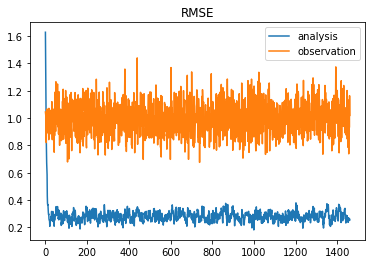

In [33]:
#Optimal Interpolation
def L96(Xa,F):
    N=len(Xa)
    
    F_ = (np.roll(Xa, -1) - np.roll(Xa, 2)) * np.roll(Xa, 1) -  Xa + F
    
    return F_

#4次のルンゲクッタ
def Rungekutta4(Xa,h,F):
    N=len(Xa)
    #K1=np.linspace(1,N,N)
    #K2=np.linspace(1,N,N)
    #K3=np.linspace(1,N,N)
    #K4=np.linspace(1,N,N)
    
    F_ = L96(Xa,F)
    K1 = h*F_

    X2=Xa+K1/2
    F_ = L96(X2,F)
    K2=h*F_
    
    X3=Xa+K2/2
    F_ = L96(X3,F)
    K3=h*F_
    
    X4=Xa+K3
    F_ = L96(X4,F)
    K4=h*F_
    
    Xb=Xa+K1/6+K2/3+K3/3+K4/6
    
    return Xb

def H3(X,mask):
    X_=X[mask]
    return np.sqrt(X_*X_)
def H3_t(X,dX,mask):
    H = np.diag(np.sqrt(X*X)/X)
    Ht = H[mask]
    return Ht@dX
def H3_adj(X,dY,mask):
    H = np.diag(np.sqrt(X*X)/X)
    Hadj = H[mask].T
    return Hadj@dY

def Forecast(Xa,B):
    
    Xf = Rungekutta4(Xa,h,F)
    #カルマンフィルターでは時間発展する、3次元変分法では定数
    Pf = B
    
    return Xf,Pf

def Analysis(Xf,Pf,y):
    H = np.eye(N)
    H2 = H/2 + np.roll(H,1,axis=1)/2
    #mask = y>=0
    #y_ = y[mask]
    #e = np.ones(N)
    #p = int(np.sum(e[mask]))
    #R = np.eye(p)
    R = np.eye(N)
    I = np.eye(N)
    
    
    d = y - H @ Xf
    #d = y_ - H3(Xf,mask)
    R_inv=np.linalg.inv(R)
    B_inv=np.linalg.inv(Pf)
    
    """Ex = np.eye(N)
    Ey = np.eye(p)
    H3t=np.zeros((N,p))
    H3adj=np.zeros((p,N))
    for i in range(N):
        H3t[i] = H3_t(Xf,Ex[i],mask)
    for i in range(p):
        H3adj[i] = H3_adj(Xf,Ey[i],mask)
    H3t = H3t.T
    H3adj = H3adj.T
    #print(H3t,H3adj)"""
    
    #A = B_inv + H3adj @ R_inv @ H3t
    
    Xa = Xf + np.linalg.inv(B_inv + H.T @ R_inv @ H) @ H.T @ R_inv @ d
    #Xa = Xf + np.linalg.inv(A) @ H3adj @ R_inv @ d
    
    return Xa


t = 1460
N = 40
h = 0.05 
F = 2.0

X = []
P = []
Pt2 = []
P2 = []
errcov = []

dataset = pd.read_csv("observation_test.csv")
y = dataset.values
y = y.reshape(1460,N)
dataset2 = pd.read_csv("test.csv")
Xt = dataset2.values.reshape(t,N)

#初期値
Xa = np.random.randn(N)
X0 = Xa
for j in range(500):
    Xa = Rungekutta4(X0,h,F)
    X0 = Xa
B = np.eye(N) * 0.2
#B = L*0.2
#print(Xa)
#print(B)
#X.append(Xa
    


for k in range(t):
    (Xf,Pf) = Forecast(Xa,B)
    Xa = Analysis(Xf,Pf,y[k,:])
    X.append(Xa)
    if(k%100==0):
        print(k)
    
Xa = np.array(X)
#print(Xa)

C1 = []
C2 = []
H = np.eye(N)
H2 = H/2 + np.roll(H,1,axis=1)/2
for i in range(1460):
    X1 = Xa[i]
    X2 = Xt[i]
    X3 = sum((X2-X1)*(X2-X1))/N
    Y1 = y[i]
    #mask = Y1>=0
    #Y1 = Y1[mask]
    #e = np.ones(N)
    #p = int(np.sum(e[mask]))
    Y2 = sum((H@X2-Y1)*(H@X2-Y1))/N
    #Y2 = sum((H3(X2,mask)-Y1)*(H3(X2,mask)-Y1))/p
    rmse1 = np.sqrt(X3)
    rmse2 = np.sqrt(Y2)
    C1.append(rmse1)
    C2.append(rmse2)
plt.plot(C1,label="analysis")
plt.plot(C2,label="observation")
#plt.plot(errcov,label="Pa")
plt.legend()
plt.title("RMSE")
#plt.savefig("KFrmse2.jpg")
plt.show()

In [2]:
def L96(Xa,F):
    N=len(Xa)
    
    F_ = (np.roll(Xa, -1) - np.roll(Xa, 2)) * np.roll(Xa, 1) -  Xa + F
    
    return F_

In [3]:
#4次のルンゲクッタ
def Rungekutta4(Xa,h,F):
    N=len(Xa)
    #K1=np.linspace(1,N,N)
    #K2=np.linspace(1,N,N)
    #K3=np.linspace(1,N,N)
    #K4=np.linspace(1,N,N)
    
    F_ = L96(Xa,F)
    K1 = h*F_

    X2=Xa+K1/2
    F_ = L96(X2,F)
    K2=h*F_
    
    X3=Xa+K2/2
    F_ = L96(X3,F)
    K3=h*F_
    
    X4=Xa+K3
    F_ = L96(X4,F)
    K4=h*F_
    
    Xb=Xa+K1/6+K2/3+K3/3+K4/6
    
    return Xb

In [2]:
def L96_t(X0,X1,F):
    return (np.roll(X0,-1,axis=0) - np.roll(X0,2,axis=0))*np.roll(X1,1,axis=0) + (np.roll(X1,-1,axis=0) - np.roll(X1,2,axis=0))*np.roll(X0,1,axis=0) - X1

def Rungekutta4_t(X0,X1,h,F):
    N=len(X0)
    
    K1 = h*L96(X0,F)
    dK1 = h*L96_t(X0,X1,F)
    
    X2 = X0 + K1/2
    dX2 = X1 + dK1/2
    K2 = h*L96(X2,F)
    dK2 = h*L96_t(X2,dX2,F)
    
    X3 = X0 + K2/2
    dX3 = X1 + dK2/2
    K3 = h*L96(X3,F)
    dK3 = h*L96_t(X3,dX3,F)
    
    X4 = X0 + K3
    dX4 = X1 + dK3
    K4 = h*L96(X4,F)
    dK4 = h*L96_t(X4,dX4,F)
    
    dXb = X1 + dK1/6 + dK2/3 + dK3/3 + dK4/6
    
    return dXb

In [3]:
def L96_adj(dXb,X0,F):
    return np.roll(X0,2,axis=0)*np.roll(dXb,1,axis=0) + (np.roll(X0,-2,axis=0) - np.roll(X0,1,axis=0))*np.roll(dXb,-1,axis=0) - np.roll(X0,-1,axis=0)*np.roll(dXb,-2,axis=0) - dXb

def Rungekutta4_adj(dXb,X0,h,F):
    K1 = h*L96(X0,F)
    X2 = X0 + K1/2
    K2 = h*L96(X2,F)
    X3 = X0 + K2/2
    K3 = h*L96(X3,F)
    X4 = X0 + K3
    K4 = h*L96(X4,F)
    
    X1 = dXb
    dK1 = dXb/6
    dK2 = dXb/3
    dK3 = dXb/3
    dK4 = dXb/6
    #print(X1,dK1,dK2,dK3,dK4)
    
    X1 = X1 + h*L96_adj(dK4,X4,F)
    dK1 = dK1
    dK2 = dK2
    dK3 = dK3 + h*L96_adj(dK4,X4,F)
    #print(X1,dK1,dK2,dK3)
    
    X1 = X1 + h*L96_adj(dK3,X3,F)
    dK1 = dK1
    dK2 = dK2 + h*L96_adj(dK3,X3,F)/2
    #print(X1,dK1,dK2)
    
    X1 = X1 + h*L96_adj(dK2,X2,F)
    dK1 = dK1 + h*L96_adj(dK2,X2,F)/2
    #print(X1,dK1)
    
    X1 = X1 + h*L96_adj(dK1,X0,F)
    #print(X1)
    
    return X1

In [9]:
N=40
m=10
h=0.05
F=8.0
X1 = np.random.rand(N)
X0 = np.ones(N)
Ax = Rungekutta4_t(X0,X1,h,F)
AtAx = Rungekutta4_adj(Ax,X0,h,F)
a = Ax.T@Ax
b = X1.T@AtAx
print(a.shape)
print(a-b)

()
1.7763568394002505e-15


In [38]:
#4dVar with Cholesky decomposition
def H3(X,mask):
    X_=X[mask]
    return np.sqrt(X_*X_)
def H3_t(X,dX,mask):
    H = np.diag(np.sqrt(X*X)/X)
    Ht = H[mask]
    return Ht@dX
def H3_adj(X,dY,mask):
    H = np.diag(np.sqrt(X*X)/X)
    Hadj = H[mask].T
    return Hadj@dY

def Forecast(Xa,B):
    
    Xf = Rungekutta4(Xa,h,F)
   
    #M = get_linear(Xa,h,F,N)
    #Pf = M @ Pa @ M.T #カルマンフィルターでは時間発展する、3次元変分法では定数
    Pf = B
    
    return Xf,Pf

def Analysis(Xf,B,y,a_window):
    H = np.eye(N)
    #H2 = H/2 + np.roll(H,1,axis=1)/2
    #mask = y>=0
    #y_ = y[mask]
    #e = np.ones(N)
    #p = int(np.sum(e[mask]))
    #R = np.eye(p)
    """Ex = np.eye(N)
    Ey = np.eye(p)
    H3t=np.zeros((N,p))
    H3adj=np.zeros((p,N))
    for i in range(N):
        H3t[i] = H3_t(Xf,Ex[i],mask)
    for i in range(p):
        H3adj[i] = H3_adj(Xf,Ey[i],mask)
    H3t = H3t.T
    H3adj = H3adj.T
    #print(H3t,H3adj)"""
    R = np.eye(N)
    E = np.eye(N)
    
    R_inv=np.linalg.inv(R)
    B_inv=np.linalg.inv(B)
      
    Fcst = [] #基本場
    xb = Xf
    Fcst.append(xb)
    for k in range(a_window):
        Xf_ = Rungekutta4(xb,h,F)
        Fcst.append(Xf_)
        xb = Xf_
        
    M = [] #TLM
    Mk = np.eye(N)
    M.append(Mk)
    MT = [] #ADM
    MkT = np.eye(N)
    MT.append(MkT)
    for k in range(a_window):
        xk = Fcst[k].reshape(-1,1)
        Mk_ = Rungekutta4_t(xk,E,h,F)
        MkT_ = Rungekutta4_adj(E,xk,h,F)
        Mk = Mk_@M[k]
        MkT = MT[k]@MkT_
        M.append(Mk)
        MT.append(MkT)
    print(len(M),len(MT))
    
    U = np.linalg.cholesky(B)
    dv0 = np.zeros(N)
    dv = CG(dv0,U,R_inv,H,y,Fcst,M,MT,a_window)
    X = U@dv
    Xa = X + Xf
    
    return Xa,M,MT

def J(dv,U,R_inv,H,y,Fcst,M,a_window):
    j = 0
    for k in range(a_window+1):
        xk = Fcst[k]
        yk = y[k]
        dk = yk-H@xk
        Mk = M[k]
        j += (H@Mk@U@dv-dk).T@R_inv@(H@Mk@U@dv-dk)/2
    return j+dv.T@dv/2

def jacobi(dv,U,R_inv,H,y,Fcst,M,MT,a_window):
    H_t = H.T
    
    p = np.zeros(N)
    for k in range(a_window+1):
        xk = Fcst[k]
        yk = y[k]
        dk = yk-H@xk
        Mk = M[k]
        MkT = MT[k]
        p += U.T@MkT@H_t@R_inv@(H@Mk@U@dv-dk)
         
    return p+dv

def CG(dv0,U,R_inv,H,y,Fcst,M,MT,a_window):
    d0 = -jacobi(dv0,U,R_inv,H,y,Fcst,M,MT,a_window)
    for k in range(1000):
        #alpha = golden_section(d0,dv0,U,R_inv,H,y,Fcst,M,MT,a_window)
        alpha=0.01
        dv = dv0 + alpha*d0
        d = jacobi(dv,U,R_inv,H,y,Fcst,M,MT,a_window)
        #err = np.sqrt(np.sum(d**2))
        #print(k,err)          
        if(np.sqrt(np.sum(d**2))<0.001):
            print(k,"end")
            break
        p = -d + (np.dot(d.T,d)/np.dot(d0.T,d0))*d0
        dv0 = dv
        d0 = p
    return dv

def golden_section(d0,dv0,U,R_inv,H,y,Fcst,M,MT,a_window):
    a0=1e-2
    b0=1
    t = (-1+np.sqrt(5))/2#golden_ratio
    a=a0
    b=b0
    c1=b-t*(b-a)
    c2=a+t*(b-a)
    num=0
    #print(num,a,b,c1,c2,abs(b-a))
    while abs(b-a)/2>0.0001:
        num+=1
        f1 = fj(c1,d0,dv0,U,R_inv,H,y,Fcst,M,MT,a_window)
        #dv1 = dv0 + c1*d0
        #f1 = J(dv1,U,R_inv,H,y,Fcst,M,a_window)
        f2 = fj(c2,d0,dv0,U,R_inv,H,y,Fcst,M,MT,a_window)
        #dv2 = dv0 + c2*d0
        #f2 = J(dv2,U,R_inv,H,y,Fcst,M,a_window)
        if(f2>f1):
            a=a
            b=c2
            c2=c1
            c1=b-t*(b-a)
        else:
            a=c1
            b=b
            c1=c2
            c2=a+t*(b-a)
    alpha = (a+b)/2    
    #print(num,"end",alpha)
    return alpha

def fj(c,d0,dv0,U,R_inv,H,y,Fcst,M,MT,a_window):
    dv = dv0 + c*d0
    return J(dv,U,R_inv,H,y,Fcst,M,a_window)

[0, 11, 22, 33, 44, 55, 66, 77, 88, 99, 110, 121, 132, 143, 154, 165, 176, 187, 198, 209, 220, 231, 242, 253, 264, 275, 286, 297, 308, 319, 330, 341, 352, 363, 374, 385, 396, 407, 418, 429, 440, 451, 462, 473, 484, 495, 506, 517, 528, 539, 550, 561, 572, 583, 594, 605, 616, 627, 638, 649, 660, 671, 682, 693, 704, 715, 726, 737, 748, 759, 770, 781, 792, 803, 814, 825, 836, 847, 858, 869, 880, 891, 902, 913, 924, 935, 946, 957, 968, 979, 990, 1001, 1012, 1023, 1034, 1045, 1056, 1067, 1078, 1089, 1100, 1111, 1122, 1133, 1144, 1155, 1166, 1177, 1188, 1199, 1210, 1221, 1232, 1243, 1254, 1265, 1276, 1287, 1298, 1309, 1320, 1331, 1342, 1353, 1364, 1375, 1386, 1397]
(11, 40)
11 11
314 end
0
(11, 40)
11 11
284 end
11
(11, 40)
11 11
292 end
22
(11, 40)
11 11
272 end
33
(11, 40)
11 11
277 end
44
(11, 40)
11 11
279 end
55
(11, 40)
11 11
275 end
66
(11, 40)
11 11
283 end
77
(11, 40)
11 11
286 end
88
(11, 40)
11 11
266 end
99
(11, 40)
11 11
270 end
110
(11, 40)
11 11
288 end
121
(11, 40)
11 11
273 e

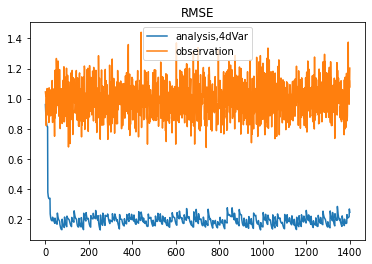

[0, 12, 24, 36, 48, 60, 72, 84, 96, 108, 120, 132, 144, 156, 168, 180, 192, 204, 216, 228, 240, 252, 264, 276, 288, 300, 312, 324, 336, 348, 360, 372, 384, 396, 408, 420, 432, 444, 456, 468, 480, 492, 504, 516, 528, 540, 552, 564, 576, 588, 600, 612, 624, 636, 648, 660, 672, 684, 696, 708, 720, 732, 744, 756, 768, 780, 792, 804, 816, 828, 840, 852, 864, 876, 888, 900, 912, 924, 936, 948, 960, 972, 984, 996, 1008, 1020, 1032, 1044, 1056, 1068, 1080, 1092, 1104, 1116, 1128, 1140, 1152, 1164, 1176, 1188, 1200, 1212, 1224, 1236, 1248, 1260, 1272, 1284, 1296, 1308, 1320, 1332, 1344, 1356, 1368, 1380, 1392]
(12, 40)
12 12
287 end
0
(12, 40)
12 12
272 end
12
(12, 40)
12 12
277 end
24
(12, 40)
12 12
262 end
36
(12, 40)
12 12
290 end
48
(12, 40)
12 12
280 end
60
(12, 40)
12 12
273 end
72
(12, 40)
12 12
282 end
84
(12, 40)
12 12
267 end
96
(12, 40)
12 12
261 end
108
(12, 40)
12 12
284 end
120
(12, 40)
12 12
270 end
132
(12, 40)
12 12
272 end
144
(12, 40)
12 12
276 end
156
(12, 40)
12 12
276 end


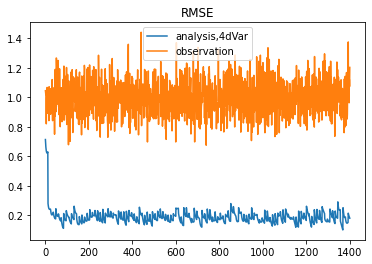

[0, 13, 26, 39, 52, 65, 78, 91, 104, 117, 130, 143, 156, 169, 182, 195, 208, 221, 234, 247, 260, 273, 286, 299, 312, 325, 338, 351, 364, 377, 390, 403, 416, 429, 442, 455, 468, 481, 494, 507, 520, 533, 546, 559, 572, 585, 598, 611, 624, 637, 650, 663, 676, 689, 702, 715, 728, 741, 754, 767, 780, 793, 806, 819, 832, 845, 858, 871, 884, 897, 910, 923, 936, 949, 962, 975, 988, 1001, 1014, 1027, 1040, 1053, 1066, 1079, 1092, 1105, 1118, 1131, 1144, 1157, 1170, 1183, 1196, 1209, 1222, 1235, 1248, 1261, 1274, 1287, 1300, 1313, 1326, 1339, 1352, 1365, 1378, 1391]
(13, 40)
13 13
298 end
0
(13, 40)
13 13
281 end
13
(13, 40)
13 13
274 end
26
(13, 40)
13 13
295 end
39
(13, 40)
13 13
275 end
52
(13, 40)
13 13
272 end
65
(13, 40)
13 13
281 end
78
(13, 40)
13 13
285 end
91
(13, 40)
13 13
265 end
104
(13, 40)
13 13
270 end
117
(13, 40)
13 13
280 end
130
(13, 40)
13 13
277 end
143
(13, 40)
13 13
275 end
156
(13, 40)
13 13
276 end
169
(13, 40)
13 13
273 end
182
(13, 40)
13 13
275 end
195
(13, 40)
13 13

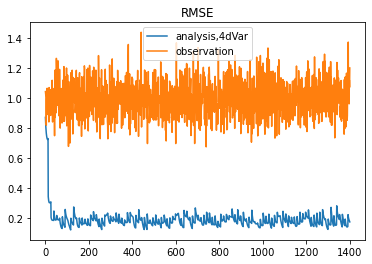

[0, 14, 28, 42, 56, 70, 84, 98, 112, 126, 140, 154, 168, 182, 196, 210, 224, 238, 252, 266, 280, 294, 308, 322, 336, 350, 364, 378, 392, 406, 420, 434, 448, 462, 476, 490, 504, 518, 532, 546, 560, 574, 588, 602, 616, 630, 644, 658, 672, 686, 700, 714, 728, 742, 756, 770, 784, 798, 812, 826, 840, 854, 868, 882, 896, 910, 924, 938, 952, 966, 980, 994, 1008, 1022, 1036, 1050, 1064, 1078, 1092, 1106, 1120, 1134, 1148, 1162, 1176, 1190, 1204, 1218, 1232, 1246, 1260, 1274, 1288, 1302, 1316, 1330, 1344, 1358, 1372, 1386]
(14, 40)
14 14
285 end
0
(14, 40)
14 14
279 end
14
(14, 40)
14 14
282 end
28
(14, 40)
14 14
287 end
42
(14, 40)
14 14
267 end
56
(14, 40)
14 14
267 end
70
(14, 40)
14 14
280 end
84
(14, 40)
14 14
258 end
98
(14, 40)
14 14
256 end
112
(14, 40)
14 14
276 end
126
(14, 40)
14 14
258 end
140
(14, 40)
14 14
276 end
154
(14, 40)
14 14
275 end
168
(14, 40)
14 14
275 end
182
(14, 40)
14 14
280 end
196
(14, 40)
14 14
280 end
210
(14, 40)
14 14
289 end
224
(14, 40)
14 14
256 end
238
(14

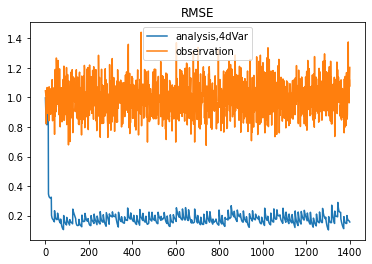

[0, 15, 30, 45, 60, 75, 90, 105, 120, 135, 150, 165, 180, 195, 210, 225, 240, 255, 270, 285, 300, 315, 330, 345, 360, 375, 390, 405, 420, 435, 450, 465, 480, 495, 510, 525, 540, 555, 570, 585, 600, 615, 630, 645, 660, 675, 690, 705, 720, 735, 750, 765, 780, 795, 810, 825, 840, 855, 870, 885, 900, 915, 930, 945, 960, 975, 990, 1005, 1020, 1035, 1050, 1065, 1080, 1095, 1110, 1125, 1140, 1155, 1170, 1185, 1200, 1215, 1230, 1245, 1260, 1275, 1290, 1305, 1320, 1335, 1350, 1365, 1380, 1395]
(15, 40)
15 15
267 end
0
(15, 40)
15 15
275 end
15
(15, 40)
15 15
262 end
30
(15, 40)
15 15
278 end
45
(15, 40)
15 15
274 end
60
(15, 40)
15 15
275 end
75
(15, 40)
15 15
286 end
90
(15, 40)
15 15
265 end
105
(15, 40)
15 15
281 end
120
(15, 40)
15 15
263 end
135
(15, 40)
15 15
283 end
150
(15, 40)
15 15
283 end
165
(15, 40)
15 15
274 end
180
(15, 40)
15 15
271 end
195
(15, 40)
15 15
280 end
210
(15, 40)
15 15
287 end
225
(15, 40)
15 15
275 end
240
(15, 40)
15 15
283 end
255
(15, 40)
15 15
270 end
270
(15, 

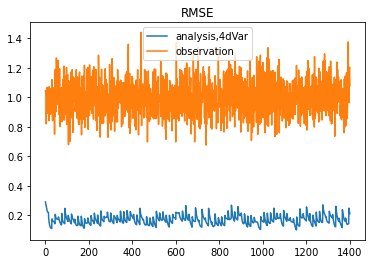

[0, 16, 32, 48, 64, 80, 96, 112, 128, 144, 160, 176, 192, 208, 224, 240, 256, 272, 288, 304, 320, 336, 352, 368, 384, 400, 416, 432, 448, 464, 480, 496, 512, 528, 544, 560, 576, 592, 608, 624, 640, 656, 672, 688, 704, 720, 736, 752, 768, 784, 800, 816, 832, 848, 864, 880, 896, 912, 928, 944, 960, 976, 992, 1008, 1024, 1040, 1056, 1072, 1088, 1104, 1120, 1136, 1152, 1168, 1184, 1200, 1216, 1232, 1248, 1264, 1280, 1296, 1312, 1328, 1344, 1360, 1376, 1392]
(16, 40)
16 16
302 end
0
(16, 40)
16 16
295 end
16
(16, 40)
16 16
282 end
32
(16, 40)
16 16
289 end
48
(16, 40)
16 16
277 end
64
(16, 40)
16 16
281 end
80
(16, 40)
16 16
269 end
96
(16, 40)
16 16
257 end
112
(16, 40)
16 16
276 end
128
(16, 40)
16 16
270 end
144
(16, 40)
16 16
264 end
160
(16, 40)
16 16
270 end
176
(16, 40)
16 16
282 end
192
(16, 40)
16 16
275 end
208
(16, 40)
16 16
286 end
224
(16, 40)
16 16
276 end
240
(16, 40)
16 16
282 end
256
(16, 40)
16 16
274 end
272
(16, 40)
16 16
263 end
288
(16, 40)
16 16
274 end
304
(16, 40)
1

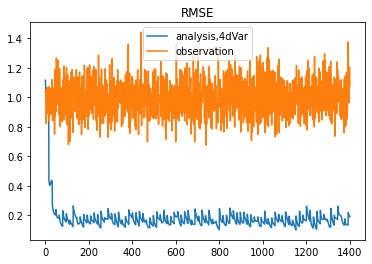

[0, 17, 34, 51, 68, 85, 102, 119, 136, 153, 170, 187, 204, 221, 238, 255, 272, 289, 306, 323, 340, 357, 374, 391, 408, 425, 442, 459, 476, 493, 510, 527, 544, 561, 578, 595, 612, 629, 646, 663, 680, 697, 714, 731, 748, 765, 782, 799, 816, 833, 850, 867, 884, 901, 918, 935, 952, 969, 986, 1003, 1020, 1037, 1054, 1071, 1088, 1105, 1122, 1139, 1156, 1173, 1190, 1207, 1224, 1241, 1258, 1275, 1292, 1309, 1326, 1343, 1360, 1377, 1394]
(17, 40)
17 17
296 end
0
(17, 40)
17 17
290 end
17
(17, 40)
17 17
266 end
34
(17, 40)
17 17
277 end
51
(17, 40)
17 17
265 end
68
(17, 40)
17 17
287 end
85
(17, 40)
17 17
272 end
102
(17, 40)
17 17
277 end
119
(17, 40)
17 17
258 end
136
(17, 40)
17 17
272 end
153
(17, 40)
17 17
271 end
170
(17, 40)
17 17
272 end
187
(17, 40)
17 17
280 end
204
(17, 40)
17 17
294 end
221
(17, 40)
17 17
254 end
238
(17, 40)
17 17
282 end
255
(17, 40)
17 17
274 end
272
(17, 40)
17 17
262 end
289
(17, 40)
17 17
269 end
306
(17, 40)
17 17
257 end
323
(17, 40)
17 17
274 end
340
(17, 40

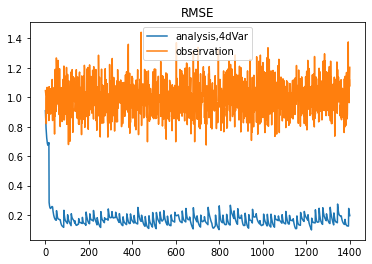

[0, 18, 36, 54, 72, 90, 108, 126, 144, 162, 180, 198, 216, 234, 252, 270, 288, 306, 324, 342, 360, 378, 396, 414, 432, 450, 468, 486, 504, 522, 540, 558, 576, 594, 612, 630, 648, 666, 684, 702, 720, 738, 756, 774, 792, 810, 828, 846, 864, 882, 900, 918, 936, 954, 972, 990, 1008, 1026, 1044, 1062, 1080, 1098, 1116, 1134, 1152, 1170, 1188, 1206, 1224, 1242, 1260, 1278, 1296, 1314, 1332, 1350, 1368, 1386]
(18, 40)
18 18
268 end
0
(18, 40)
18 18
274 end
18
(18, 40)
18 18
262 end
36
(18, 40)
18 18
270 end
54
(18, 40)
18 18
268 end
72
(18, 40)
18 18
285 end
90
(18, 40)
18 18
257 end
108
(18, 40)
18 18
275 end
126
(18, 40)
18 18
268 end
144
(18, 40)
18 18
270 end
162
(18, 40)
18 18
274 end
180
(18, 40)
18 18
274 end
198
(18, 40)
18 18
273 end
216
(18, 40)
18 18
276 end
234
(18, 40)
18 18
292 end
252
(18, 40)
18 18
270 end
270
(18, 40)
18 18
259 end
288
(18, 40)
18 18
266 end
306
(18, 40)
18 18
259 end
324
(18, 40)
18 18
262 end
342
(18, 40)
18 18
286 end
360
(18, 40)
18 18
282 end
378
(18, 40

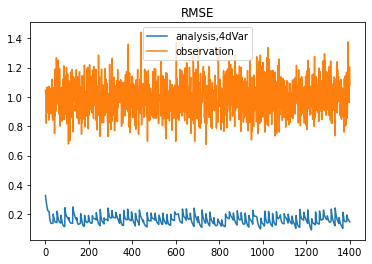

[0, 19, 38, 57, 76, 95, 114, 133, 152, 171, 190, 209, 228, 247, 266, 285, 304, 323, 342, 361, 380, 399, 418, 437, 456, 475, 494, 513, 532, 551, 570, 589, 608, 627, 646, 665, 684, 703, 722, 741, 760, 779, 798, 817, 836, 855, 874, 893, 912, 931, 950, 969, 988, 1007, 1026, 1045, 1064, 1083, 1102, 1121, 1140, 1159, 1178, 1197, 1216, 1235, 1254, 1273, 1292, 1311, 1330, 1349, 1368, 1387]
(19, 40)
19 19
287 end
0
(19, 40)
19 19
288 end
19
(19, 40)
19 19
302 end
38
(19, 40)
19 19
260 end
57
(19, 40)
19 19
275 end
76
(19, 40)
19 19
266 end
95
(19, 40)
19 19
262 end
114
(19, 40)
19 19
248 end
133
(19, 40)
19 19
271 end
152
(19, 40)
19 19
267 end
171
(19, 40)
19 19
273 end
190
(19, 40)
19 19
279 end
209
(19, 40)
19 19
280 end
228
(19, 40)
19 19
247 end
247
(19, 40)
19 19
269 end
266
(19, 40)
19 19
274 end
285
(19, 40)
19 19
274 end
304
(19, 40)
19 19
253 end
323
(19, 40)
19 19
261 end
342
(19, 40)
19 19
281 end
361
(19, 40)
19 19
280 end
380
(19, 40)
19 19
271 end
399
(19, 40)
19 19
256 end
418
(

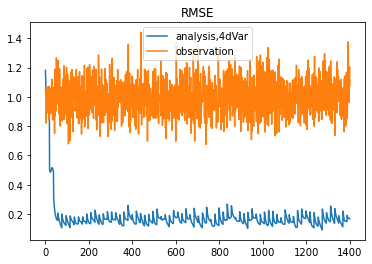

[0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 240, 260, 280, 300, 320, 340, 360, 380, 400, 420, 440, 460, 480, 500, 520, 540, 560, 580, 600, 620, 640, 660, 680, 700, 720, 740, 760, 780, 800, 820, 840, 860, 880, 900, 920, 940, 960, 980, 1000, 1020, 1040, 1060, 1080, 1100, 1120, 1140, 1160, 1180, 1200, 1220, 1240, 1260, 1280, 1300, 1320, 1340, 1360, 1380]
(20, 40)
20 20
281 end
0
(20, 40)
20 20
284 end
20
(20, 40)
20 20
285 end
40
(20, 40)
20 20
273 end
60
(20, 40)
20 20
277 end
80
(20, 40)
20 20
256 end
100
(20, 40)
20 20
281 end
120
(20, 40)
20 20
251 end
140
(20, 40)
20 20
261 end
160
(20, 40)
20 20
272 end
180
(20, 40)
20 20
274 end
200
(20, 40)
20 20
291 end
220
(20, 40)
20 20
274 end
240
(20, 40)
20 20
265 end
260
(20, 40)
20 20
262 end
280
(20, 40)
20 20
264 end
300
(20, 40)
20 20
265 end
320
(20, 40)
20 20
273 end
340
(20, 40)
20 20
286 end
360
(20, 40)
20 20
280 end
380
(20, 40)
20 20
274 end
400
(20, 40)
20 20
247 end
420
(20, 40)
20 20
267 end
440
(20, 40)
20 20
263 e

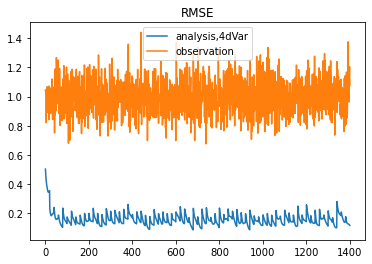

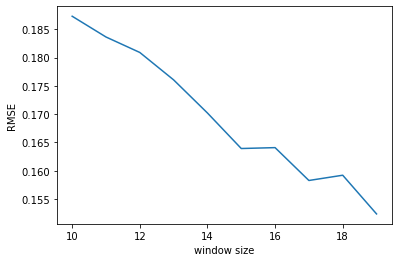

In [40]:
import time
t = 1400
N = 40
h = 0.05 
F = 2.0

dataset = pd.read_csv("observation_test.csv")
y = dataset.values
y = y.reshape(1460,N)
dataset2 = pd.read_csv("test.csv")
Xt = dataset2.values.reshape(1460,N)

#print(Xa)
#print(B)
#X.append(Xa
RMSE=[]
TLM=[]
A=[]
for i in range(10,20):
    #i=5
    start = time.time()
    X = []

    #初期値
    Xa = np.random.randn(N)
    X0 = Xa
    for j in range(500):
        Xa = Rungekutta4(X0,h,F)
        X0 = Xa
    #X.append(Xa)
    
    B = np.eye(N) * 0.2
    
    a_window = i

    Time=range(0,t,a_window+1)
    print(list(Time))
    
    for k in Time:
        (Xf,B) = Forecast(Xa,B)
        obs = y[k:k+a_window+1,:]
        print(obs.shape)
        (Xa,M,MT) = Analysis(Xf,B,obs,a_window)
        X.append(Xa)
        TLM.append(M)
        for l in range(a_window):
            Xb = Rungekutta4(Xa,h,F)
            X.append(Xb)
            Xa = Xb
        #if(k%100==0):
        print(k)

    elapsed_time = time.time()-start
    print("elapsed_time:{0}".format(elapsed_time) + "[sec]")
    print(np.array(TLM).shape)

    #XA = np.array(X)
#print(Xa)

    C1_ = []
    C2_ = []
    H = np.eye(N)
#H2 = H/2 + np.roll(H,1,axis=1)/2
    for i in range(t):
        X1 = X[i]
        X2 = Xt[i]
        X3 = sum((X2-X1)*(X2-X1))/N
        Y1 = y[i]
    #mask = Y1>=0
    #Y1 = Y1[mask]
    #e = np.eye(N)
    #p = int(np.sum(e[mask]))
        Y2 = sum((H@X2-Y1)*(H@X2-Y1))/N
    #Y2 = sum((H3(X2,mask)-Y1)*(H3(X2,mask)-Y1))/p
        rmse1 = np.sqrt(X3)
        rmse2 = np.sqrt(Y2)
        C1_.append(rmse1)
        C2_.append(rmse2)
    #plt.plot(C1,label="analysis,OI")
    plt.plot(C1_,label="analysis,4dVar")
    plt.plot(C2_,label="observation")
#plt.plot(errcov,label="Pa")
    plt.legend()
    plt.title("RMSE")
    #plt.savefig("4dVar_window"+str(a_window)+"2.jpg")
    plt.show()
    
    r=np.mean(np.array(C1_[500:]))
    RMSE.append(r)
    A.append(a_window)
    
plt.plot(A,RMSE)
plt.xlabel("window size")
plt.ylabel("RMSE")
#plt.savefig("4dVar_windowsize2.jpg")
plt.show()

In [4]:
#4dVar with scipy.optimize
def L96(Xa,F):
    N=len(Xa)
    
    F_ = (np.roll(Xa, -1) - np.roll(Xa, 2)) * np.roll(Xa, 1) -  Xa + F
    
    return F_

#4次のルンゲクッタ
def Rungekutta4(Xa,h,F):
    N=len(Xa)
    #K1=np.linspace(1,N,N)
    #K2=np.linspace(1,N,N)
    #K3=np.linspace(1,N,N)
    #K4=np.linspace(1,N,N)
    
    F_ = L96(Xa,F)
    K1 = h*F_

    X2=Xa+K1/2
    F_ = L96(X2,F)
    K2=h*F_
    
    X3=Xa+K2/2
    F_ = L96(X3,F)
    K3=h*F_
    
    X4=Xa+K3
    F_ = L96(X4,F)
    K4=h*F_
    
    Xb=Xa+K1/6+K2/3+K3/3+K4/6
    
    return Xb

def H3(X,mask):
    X_=X[mask]
    return np.sqrt(X_*X_)
def H3_t(X,dX,mask):
    H = np.diag(np.sqrt(X*X)/X)
    Ht = H[mask]
    return Ht@dX
def H3_adj(X,dY,mask):
    H = np.diag(np.sqrt(X*X)/X)
    Hadj = H[mask].T
    return Hadj@dY

def Forecast(Xa,B):
    
    Xf = Rungekutta4(Xa,h,F)
   
    #M = get_linear(Xa,h,F,N)
    #Pf = M @ Pa @ M.T #カルマンフィルターでは時間発展する、3次元変分法では定数
    Pf = B
    
    return Xf,Pf

def Analysis(Xf,B,y,a_window):
    from scipy import optimize
    
    H = np.eye(N)
    #H2 = H/2 + np.roll(H,1,axis=1)/2
    #mask = y>=0
    #y_ = y[mask]
    #e = np.ones(N)
    #p = int(np.sum(e[mask]))
    #R = np.eye(p)
    """Ex = np.eye(N)
    Ey = np.eye(p)
    H3t=np.zeros((N,p))
    H3adj=np.zeros((p,N))
    for i in range(N):
        H3t[i] = H3_t(Xf,Ex[i],mask)
    for i in range(p):
        H3adj[i] = H3_adj(Xf,Ey[i],mask)
    H3t = H3t.T
    H3adj = H3adj.T
    #print(H3t,H3adj)"""
    R = np.eye(N)
    E = np.eye(N)
    
    R_inv=np.linalg.inv(R)
    B_inv=np.linalg.inv(B)
      
    Fcst = [] #基本場
    xb = Xf
    Fcst.append(xb)
    for k in range(a_window):
        Xf_ = Rungekutta4(xb,h,F)
        Fcst.append(Xf_)
        xb = Xf_
        
    M = [] #TLM
    Mk = np.eye(N)
    M.append(Mk)
    MT = [] #ADM
    MkT = np.eye(N)
    MT.append(MkT)
    for k in range(a_window):
        xk = Fcst[k]
        Mk_ = np.eye(N)
        MkT_ = np.eye(N)
        for l in range(N):
            e = E[l]
            Mk_[l] = Rungekutta4_t(xk,e,h,F)
            MkT_[l] = Rungekutta4_adj(e,xk,h,F)
        Mk = Mk_.T@M[k]
        MkT = MT[k]@MkT_.T
        M.append(Mk)
        MT.append(MkT)
    print(len(M),len(MT))
    
    U = np.linalg.cholesky(B)
    dv0 = np.zeros(N)
    args=(U,R_inv,H,y,Fcst,M,MT,a_window)
    res = optimize.minimize(J, dv0, args=args, method='BFGS', jac=jacobi, options={'gtol':1e-6, 'disp':True})
    dv = res.x
    jmin = res.fun
    #dv = optimize.fmin_cg(J,dv0,fprime=jacobi,args=args)
    #dv = CG(dv0,U,R_inv,H,y,Fcst,M,MT,a_window)
    X = U@dv
    Xa = X + Xf
    
    return Xa,M,MT,jmin

def J(dv,*args):
    U,R_inv,H,y,Fcst,M,MT,a_window = args
    j = 0
    for k in range(a_window+1):
        xk = Fcst[k]
        yk = y[k]
        dk = yk-H@xk
        Mk = M[k]
        j += (H@Mk@U@dv-dk).T@R_inv@(H@Mk@U@dv-dk)/2
    return j+dv.T@dv/2

def jacobi(dv,*args):
    U,R_inv,H,y,Fcst,M,MT,a_window = args
    H_t = H.T
    
    p = np.zeros(N)
    for k in range(a_window+1):
        xk = Fcst[k]
        yk = y[k]
        dk = yk-H@xk
        Mk = M[k]
        MkT = MT[k]
        p += U.T@MkT@H_t@R_inv@(H@Mk@U@dv-dk)
         
    return p+dv


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

1 1
Optimization terminated successfully.
         Current function value: 21.460176
         Iterations: 2
         Function evaluations: 3
         Gradient evaluations: 3
34
(1, 40)
1 1
Optimization terminated successfully.
         Current function value: 18.419059
         Iterations: 2
         Function evaluations: 3
         Gradient evaluations: 3
35
(1, 40)
1 1
Optimization terminated successfully.
         Current function value: 19.696272
         Iterations: 2
         Function evaluations: 3
         Gradient evaluations: 3
36
(1, 40)
1 1
Optimization terminated successfully.
         Current function value: 18.944579
         Iterations: 2
         Function evaluations: 3
         Gradient evaluations: 3
37
(1, 40)
1 1
Optimization terminated successfully.
         Current function value: 20.453613
         Iterations: 2
         Function evaluations: 3
         Gradient evaluations: 3
38
(1, 40)
1 1
Optimization terminated successfully.
         Current function value: 

1 1
Optimization terminated successfully.
         Current function value: 21.224962
         Iterations: 2
         Function evaluations: 3
         Gradient evaluations: 3
93
(1, 40)
1 1
Optimization terminated successfully.
         Current function value: 17.513116
         Iterations: 2
         Function evaluations: 3
         Gradient evaluations: 3
94
(1, 40)
1 1
Optimization terminated successfully.
         Current function value: 25.793784
         Iterations: 2
         Function evaluations: 3
         Gradient evaluations: 3
95
(1, 40)
1 1
Optimization terminated successfully.
         Current function value: 23.144304
         Iterations: 2
         Function evaluations: 3
         Gradient evaluations: 3
96
(1, 40)
1 1
Optimization terminated successfully.
         Current function value: 18.000077
         Iterations: 2
         Function evaluations: 3
         Gradient evaluations: 3
97
(1, 40)
1 1
Optimization terminated successfully.
         Current function value: 

Optimization terminated successfully.
         Current function value: 18.434865
         Iterations: 2
         Function evaluations: 3
         Gradient evaluations: 3
165
(1, 40)
1 1
Optimization terminated successfully.
         Current function value: 23.524630
         Iterations: 2
         Function evaluations: 3
         Gradient evaluations: 3
166
(1, 40)
1 1
Optimization terminated successfully.
         Current function value: 20.918054
         Iterations: 2
         Function evaluations: 3
         Gradient evaluations: 3
167
(1, 40)
1 1
Optimization terminated successfully.
         Current function value: 13.306365
         Iterations: 2
         Function evaluations: 3
         Gradient evaluations: 3
168
(1, 40)
1 1
Optimization terminated successfully.
         Current function value: 15.309704
         Iterations: 2
         Function evaluations: 3
         Gradient evaluations: 3
169
(1, 40)
1 1
Optimization terminated successfully.
         Current function value:

252
(1, 40)
1 1
Optimization terminated successfully.
         Current function value: 22.615071
         Iterations: 2
         Function evaluations: 3
         Gradient evaluations: 3
253
(1, 40)
1 1
Optimization terminated successfully.
         Current function value: 17.259914
         Iterations: 2
         Function evaluations: 3
         Gradient evaluations: 3
254
(1, 40)
1 1
Optimization terminated successfully.
         Current function value: 16.016086
         Iterations: 2
         Function evaluations: 3
         Gradient evaluations: 3
255
(1, 40)
1 1
Optimization terminated successfully.
         Current function value: 22.246666
         Iterations: 2
         Function evaluations: 3
         Gradient evaluations: 3
256
(1, 40)
1 1
Optimization terminated successfully.
         Current function value: 21.589771
         Iterations: 2
         Function evaluations: 3
         Gradient evaluations: 3
257
(1, 40)
1 1
Optimization terminated successfully.
         Current

Optimization terminated successfully.
         Current function value: 15.869943
         Iterations: 2
         Function evaluations: 3
         Gradient evaluations: 3
297
(1, 40)
1 1
Optimization terminated successfully.
         Current function value: 22.635055
         Iterations: 2
         Function evaluations: 3
         Gradient evaluations: 3
298
(1, 40)
1 1
Optimization terminated successfully.
         Current function value: 19.894336
         Iterations: 2
         Function evaluations: 3
         Gradient evaluations: 3
299
(1, 40)
1 1
Optimization terminated successfully.
         Current function value: 16.670881
         Iterations: 2
         Function evaluations: 3
         Gradient evaluations: 3
300
(1, 40)
1 1
Optimization terminated successfully.
         Current function value: 20.464207
         Iterations: 2
         Function evaluations: 3
         Gradient evaluations: 3
301
(1, 40)
1 1
Optimization terminated successfully.
         Current function value:

(1, 40)
1 1
Optimization terminated successfully.
         Current function value: 24.000873
         Iterations: 2
         Function evaluations: 3
         Gradient evaluations: 3
377
(1, 40)
1 1
Optimization terminated successfully.
         Current function value: 21.288033
         Iterations: 2
         Function evaluations: 3
         Gradient evaluations: 3
378
(1, 40)
1 1
Optimization terminated successfully.
         Current function value: 13.639755
         Iterations: 2
         Function evaluations: 3
         Gradient evaluations: 3
379
(1, 40)
1 1
Optimization terminated successfully.
         Current function value: 23.087691
         Iterations: 2
         Function evaluations: 3
         Gradient evaluations: 3
380
(1, 40)
1 1
Optimization terminated successfully.
         Current function value: 22.657139
         Iterations: 2
         Function evaluations: 3
         Gradient evaluations: 3
381
(1, 40)
1 1
Optimization terminated successfully.
         Current fun

         Current function value: 17.916488
         Iterations: 2
         Function evaluations: 3
         Gradient evaluations: 3
432
(1, 40)
1 1
Optimization terminated successfully.
         Current function value: 26.635608
         Iterations: 2
         Function evaluations: 3
         Gradient evaluations: 3
433
(1, 40)
1 1
Optimization terminated successfully.
         Current function value: 19.769244
         Iterations: 2
         Function evaluations: 3
         Gradient evaluations: 3
434
(1, 40)
1 1
Optimization terminated successfully.
         Current function value: 14.142872
         Iterations: 2
         Function evaluations: 3
         Gradient evaluations: 3
435
(1, 40)
1 1
Optimization terminated successfully.
         Current function value: 20.493261
         Iterations: 2
         Function evaluations: 3
         Gradient evaluations: 3
436
(1, 40)
1 1
Optimization terminated successfully.
         Current function value: 17.664921
         Iterations: 2
    

Optimization terminated successfully.
         Current function value: 23.367214
         Iterations: 2
         Function evaluations: 3
         Gradient evaluations: 3
498
(1, 40)
1 1
Optimization terminated successfully.
         Current function value: 19.573431
         Iterations: 2
         Function evaluations: 3
         Gradient evaluations: 3
499
(1, 40)
1 1
Optimization terminated successfully.
         Current function value: 17.820944
         Iterations: 2
         Function evaluations: 3
         Gradient evaluations: 3
500
(1, 40)
1 1
Optimization terminated successfully.
         Current function value: 16.576729
         Iterations: 2
         Function evaluations: 3
         Gradient evaluations: 3
501
(1, 40)
1 1
Optimization terminated successfully.
         Current function value: 22.333350
         Iterations: 2
         Function evaluations: 3
         Gradient evaluations: 3
502
(1, 40)
1 1
Optimization terminated successfully.
         Current function value:

(1, 40)
1 1
Optimization terminated successfully.
         Current function value: 10.818950
         Iterations: 2
         Function evaluations: 3
         Gradient evaluations: 3
546
(1, 40)
1 1
Optimization terminated successfully.
         Current function value: 13.358965
         Iterations: 2
         Function evaluations: 3
         Gradient evaluations: 3
547
(1, 40)
1 1
Optimization terminated successfully.
         Current function value: 13.259640
         Iterations: 2
         Function evaluations: 3
         Gradient evaluations: 3
548
(1, 40)
1 1
Optimization terminated successfully.
         Current function value: 11.987765
         Iterations: 2
         Function evaluations: 3
         Gradient evaluations: 3
549
(1, 40)
1 1
Optimization terminated successfully.
         Current function value: 19.972547
         Iterations: 2
         Function evaluations: 3
         Gradient evaluations: 3
550
(1, 40)
1 1
Optimization terminated successfully.
         Current fun

621
(1, 40)
1 1
Optimization terminated successfully.
         Current function value: 20.410518
         Iterations: 2
         Function evaluations: 3
         Gradient evaluations: 3
622
(1, 40)
1 1
Optimization terminated successfully.
         Current function value: 12.637057
         Iterations: 2
         Function evaluations: 3
         Gradient evaluations: 3
623
(1, 40)
1 1
Optimization terminated successfully.
         Current function value: 25.300224
         Iterations: 2
         Function evaluations: 3
         Gradient evaluations: 3
624
(1, 40)
1 1
Optimization terminated successfully.
         Current function value: 16.455574
         Iterations: 2
         Function evaluations: 3
         Gradient evaluations: 3
625
(1, 40)
1 1
Optimization terminated successfully.
         Current function value: 20.424586
         Iterations: 2
         Function evaluations: 3
         Gradient evaluations: 3
626
(1, 40)
1 1
Optimization terminated successfully.
         Current

         Current function value: 16.577577
         Iterations: 2
         Function evaluations: 3
         Gradient evaluations: 3
698
(1, 40)
1 1
Optimization terminated successfully.
         Current function value: 15.046922
         Iterations: 2
         Function evaluations: 3
         Gradient evaluations: 3
699
(1, 40)
1 1
Optimization terminated successfully.
         Current function value: 24.858739
         Iterations: 2
         Function evaluations: 3
         Gradient evaluations: 3
700
(1, 40)
1 1
Optimization terminated successfully.
         Current function value: 20.542731
         Iterations: 2
         Function evaluations: 3
         Gradient evaluations: 3
701
(1, 40)
1 1
Optimization terminated successfully.
         Current function value: 14.658915
         Iterations: 2
         Function evaluations: 3
         Gradient evaluations: 3
702
(1, 40)
1 1
Optimization terminated successfully.
         Current function value: 18.168121
         Iterations: 2
    

(1, 40)
1 1
Optimization terminated successfully.
         Current function value: 17.648986
         Iterations: 2
         Function evaluations: 3
         Gradient evaluations: 3
780
(1, 40)
1 1
Optimization terminated successfully.
         Current function value: 15.019985
         Iterations: 2
         Function evaluations: 3
         Gradient evaluations: 3
781
(1, 40)
1 1
Optimization terminated successfully.
         Current function value: 26.770437
         Iterations: 2
         Function evaluations: 3
         Gradient evaluations: 3
782
(1, 40)
1 1
Optimization terminated successfully.
         Current function value: 32.888705
         Iterations: 2
         Function evaluations: 3
         Gradient evaluations: 3
783
(1, 40)
1 1
Optimization terminated successfully.
         Current function value: 16.413369
         Iterations: 2
         Function evaluations: 3
         Gradient evaluations: 3
784
(1, 40)
1 1
Optimization terminated successfully.
         Current fun

(1, 40)
1 1
Optimization terminated successfully.
         Current function value: 18.558581
         Iterations: 2
         Function evaluations: 3
         Gradient evaluations: 3
860
(1, 40)
1 1
Optimization terminated successfully.
         Current function value: 17.234884
         Iterations: 2
         Function evaluations: 3
         Gradient evaluations: 3
861
(1, 40)
1 1
Optimization terminated successfully.
         Current function value: 18.344387
         Iterations: 2
         Function evaluations: 3
         Gradient evaluations: 3
862
(1, 40)
1 1
Optimization terminated successfully.
         Current function value: 24.068607
         Iterations: 2
         Function evaluations: 3
         Gradient evaluations: 3
863
(1, 40)
1 1
Optimization terminated successfully.
         Current function value: 28.121447
         Iterations: 2
         Function evaluations: 3
         Gradient evaluations: 3
864
(1, 40)
1 1
Optimization terminated successfully.
         Current fun

(1, 40)
1 1
Optimization terminated successfully.
         Current function value: 16.164766
         Iterations: 2
         Function evaluations: 3
         Gradient evaluations: 3
944
(1, 40)
1 1
Optimization terminated successfully.
         Current function value: 23.607775
         Iterations: 2
         Function evaluations: 3
         Gradient evaluations: 3
945
(1, 40)
1 1
Optimization terminated successfully.
         Current function value: 24.838367
         Iterations: 2
         Function evaluations: 3
         Gradient evaluations: 3
946
(1, 40)
1 1
Optimization terminated successfully.
         Current function value: 14.047758
         Iterations: 2
         Function evaluations: 3
         Gradient evaluations: 3
947
(1, 40)
1 1
Optimization terminated successfully.
         Current function value: 18.926094
         Iterations: 2
         Function evaluations: 3
         Gradient evaluations: 3
948
(1, 40)
1 1
Optimization terminated successfully.
         Current fun

Optimization terminated successfully.
         Current function value: 25.954876
         Iterations: 2
         Function evaluations: 3
         Gradient evaluations: 3
1016
(1, 40)
1 1
Optimization terminated successfully.
         Current function value: 16.485180
         Iterations: 2
         Function evaluations: 3
         Gradient evaluations: 3
1017
(1, 40)
1 1
Optimization terminated successfully.
         Current function value: 16.840578
         Iterations: 2
         Function evaluations: 3
         Gradient evaluations: 3
1018
(1, 40)
1 1
Optimization terminated successfully.
         Current function value: 30.271739
         Iterations: 2
         Function evaluations: 3
         Gradient evaluations: 3
1019
(1, 40)
1 1
Optimization terminated successfully.
         Current function value: 24.354816
         Iterations: 2
         Function evaluations: 3
         Gradient evaluations: 3
1020
(1, 40)
1 1
Optimization terminated successfully.
         Current function v

1 1
Optimization terminated successfully.
         Current function value: 22.380762
         Iterations: 2
         Function evaluations: 3
         Gradient evaluations: 3
1060
(1, 40)
1 1
Optimization terminated successfully.
         Current function value: 26.586028
         Iterations: 2
         Function evaluations: 3
         Gradient evaluations: 3
1061
(1, 40)
1 1
Optimization terminated successfully.
         Current function value: 22.543193
         Iterations: 2
         Function evaluations: 3
         Gradient evaluations: 3
1062
(1, 40)
1 1
Optimization terminated successfully.
         Current function value: 23.726036
         Iterations: 2
         Function evaluations: 3
         Gradient evaluations: 3
1063
(1, 40)
1 1
Optimization terminated successfully.
         Current function value: 26.982235
         Iterations: 2
         Function evaluations: 3
         Gradient evaluations: 3
1064
(1, 40)
1 1
Optimization terminated successfully.
         Current functi

1 1
Optimization terminated successfully.
         Current function value: 30.186090
         Iterations: 2
         Function evaluations: 3
         Gradient evaluations: 3
1122
(1, 40)
1 1
Optimization terminated successfully.
         Current function value: 10.098789
         Iterations: 2
         Function evaluations: 3
         Gradient evaluations: 3
1123
(1, 40)
1 1
Optimization terminated successfully.
         Current function value: 15.519624
         Iterations: 2
         Function evaluations: 3
         Gradient evaluations: 3
1124
(1, 40)
1 1
Optimization terminated successfully.
         Current function value: 25.944965
         Iterations: 2
         Function evaluations: 3
         Gradient evaluations: 3
1125
(1, 40)
1 1
Optimization terminated successfully.
         Current function value: 14.151219
         Iterations: 2
         Function evaluations: 3
         Gradient evaluations: 3
1126
(1, 40)
1 1
Optimization terminated successfully.
         Current functi

Optimization terminated successfully.
         Current function value: 20.311166
         Iterations: 2
         Function evaluations: 3
         Gradient evaluations: 3
1180
(1, 40)
1 1
Optimization terminated successfully.
         Current function value: 15.415941
         Iterations: 2
         Function evaluations: 3
         Gradient evaluations: 3
1181
(1, 40)
1 1
Optimization terminated successfully.
         Current function value: 29.224435
         Iterations: 2
         Function evaluations: 3
         Gradient evaluations: 3
1182
(1, 40)
1 1
Optimization terminated successfully.
         Current function value: 25.260610
         Iterations: 2
         Function evaluations: 3
         Gradient evaluations: 3
1183
(1, 40)
1 1
Optimization terminated successfully.
         Current function value: 14.420474
         Iterations: 2
         Function evaluations: 3
         Gradient evaluations: 3
1184
(1, 40)
1 1
Optimization terminated successfully.
         Current function v

(1, 40)
1 1
Optimization terminated successfully.
         Current function value: 15.120414
         Iterations: 2
         Function evaluations: 3
         Gradient evaluations: 3
1257
(1, 40)
1 1
Optimization terminated successfully.
         Current function value: 23.321792
         Iterations: 2
         Function evaluations: 3
         Gradient evaluations: 3
1258
(1, 40)
1 1
Optimization terminated successfully.
         Current function value: 28.993775
         Iterations: 2
         Function evaluations: 3
         Gradient evaluations: 3
1259
(1, 40)
1 1
Optimization terminated successfully.
         Current function value: 17.075838
         Iterations: 2
         Function evaluations: 3
         Gradient evaluations: 3
1260
(1, 40)
1 1
Optimization terminated successfully.
         Current function value: 22.798749
         Iterations: 2
         Function evaluations: 3
         Gradient evaluations: 3
1261
(1, 40)
1 1
Optimization terminated successfully.
         Curren

1 1
Optimization terminated successfully.
         Current function value: 17.598073
         Iterations: 2
         Function evaluations: 3
         Gradient evaluations: 3
1324
(1, 40)
1 1
Optimization terminated successfully.
         Current function value: 15.977452
         Iterations: 2
         Function evaluations: 3
         Gradient evaluations: 3
1325
(1, 40)
1 1
Optimization terminated successfully.
         Current function value: 11.304304
         Iterations: 2
         Function evaluations: 3
         Gradient evaluations: 3
1326
(1, 40)
1 1
Optimization terminated successfully.
         Current function value: 15.428303
         Iterations: 2
         Function evaluations: 3
         Gradient evaluations: 3
1327
(1, 40)
1 1
Optimization terminated successfully.
         Current function value: 23.154370
         Iterations: 2
         Function evaluations: 3
         Gradient evaluations: 3
1328
(1, 40)
1 1
Optimization terminated successfully.
         Current functi

1 1
Optimization terminated successfully.
         Current function value: 19.499908
         Iterations: 2
         Function evaluations: 3
         Gradient evaluations: 3
1391
(1, 40)
1 1
Optimization terminated successfully.
         Current function value: 21.061158
         Iterations: 2
         Function evaluations: 3
         Gradient evaluations: 3
1392
(1, 40)
1 1
Optimization terminated successfully.
         Current function value: 17.911415
         Iterations: 2
         Function evaluations: 3
         Gradient evaluations: 3
1393
(1, 40)
1 1
Optimization terminated successfully.
         Current function value: 20.953579
         Iterations: 2
         Function evaluations: 3
         Gradient evaluations: 3
1394
(1, 40)
1 1
Optimization terminated successfully.
         Current function value: 22.337964
         Iterations: 2
         Function evaluations: 3
         Gradient evaluations: 3
1395
(1, 40)
1 1
Optimization terminated successfully.
         Current functi

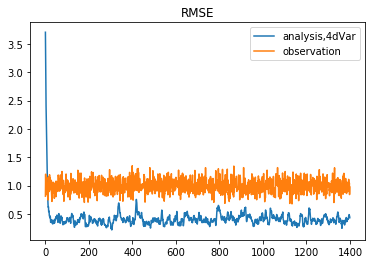

<Jmin> 20.851254978296247
[0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 398, 400, 402, 404, 406, 408, 410

2 2
Optimization terminated successfully.
         Current function value: 34.009877
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
25
(2, 40)
2 2
Optimization terminated successfully.
         Current function value: 36.246884
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
26
(2, 40)
2 2
Optimization terminated successfully.
         Current function value: 30.981740
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
27
(2, 40)
2 2
Optimization terminated successfully.
         Current function value: 24.242537
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
28
(2, 40)
2 2
Optimization terminated successfully.
         Current function value: 18.904061
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
29
(2, 40)
2 2
Optimization terminated successfully.
         Current function value: 

2 2
Optimization terminated successfully.
         Current function value: 31.852172
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
70
(2, 40)
2 2
Optimization terminated successfully.
         Current function value: 31.948740
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
71
(2, 40)
2 2
Optimization terminated successfully.
         Current function value: 36.123157
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
72
(2, 40)
2 2
Optimization terminated successfully.
         Current function value: 37.998884
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
73
(2, 40)
2 2
Optimization terminated successfully.
         Current function value: 42.922762
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
74
(2, 40)
2 2
Optimization terminated successfully.
         Current function value: 

2 2
Optimization terminated successfully.
         Current function value: 38.960977
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
116
(2, 40)
2 2
Optimization terminated successfully.
         Current function value: 43.395729
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
117
(2, 40)
2 2
Optimization terminated successfully.
         Current function value: 34.943453
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
118
(2, 40)
2 2
Optimization terminated successfully.
         Current function value: 33.442568
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
119
(2, 40)
2 2
Optimization terminated successfully.
         Current function value: 38.056471
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
120
(2, 40)
2 2
Optimization terminated successfully.
         Current function va

2 2
Optimization terminated successfully.
         Current function value: 37.435765
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
162
(2, 40)
2 2
Optimization terminated successfully.
         Current function value: 40.425985
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
163
(2, 40)
2 2
Optimization terminated successfully.
         Current function value: 36.297051
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
164
(2, 40)
2 2
Optimization terminated successfully.
         Current function value: 34.505609
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
165
(2, 40)
2 2
Optimization terminated successfully.
         Current function value: 38.111490
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
166
(2, 40)
2 2
Optimization terminated successfully.
         Current function va

2 2
Optimization terminated successfully.
         Current function value: 40.408809
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
208
(2, 40)
2 2
Optimization terminated successfully.
         Current function value: 41.622956
         Iterations: 9
         Function evaluations: 10
         Gradient evaluations: 10
209
(2, 40)
2 2
Optimization terminated successfully.
         Current function value: 38.440377
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
210
(2, 40)
2 2
Optimization terminated successfully.
         Current function value: 45.791370
         Iterations: 9
         Function evaluations: 10
         Gradient evaluations: 10
211
(2, 40)
2 2
Optimization terminated successfully.
         Current function value: 51.233342
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
212
(2, 40)
2 2
Optimization terminated successfully.
         Current functio

2 2
Optimization terminated successfully.
         Current function value: 33.826418
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
253
(2, 40)
2 2
Optimization terminated successfully.
         Current function value: 28.061296
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
254
(2, 40)
2 2
Optimization terminated successfully.
         Current function value: 35.642263
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
255
(2, 40)
2 2
Optimization terminated successfully.
         Current function value: 38.930177
         Iterations: 10
         Function evaluations: 11
         Gradient evaluations: 11
256
(2, 40)
2 2
Optimization terminated successfully.
         Current function value: 42.414257
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
257
(2, 40)
2 2
Optimization terminated successfully.
         Current function

2 2
Optimization terminated successfully.
         Current function value: 36.384797
         Iterations: 9
         Function evaluations: 10
         Gradient evaluations: 10
297
(2, 40)
2 2
Optimization terminated successfully.
         Current function value: 36.503393
         Iterations: 9
         Function evaluations: 10
         Gradient evaluations: 10
298
(2, 40)
2 2
Optimization terminated successfully.
         Current function value: 34.863113
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
299
(2, 40)
2 2
Optimization terminated successfully.
         Current function value: 39.433714
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
300
(2, 40)
2 2
Optimization terminated successfully.
         Current function value: 30.026792
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
301
(2, 40)
2 2
Optimization terminated successfully.
         Current functio

2 2
Optimization terminated successfully.
         Current function value: 42.512138
         Iterations: 9
         Function evaluations: 10
         Gradient evaluations: 10
341
(2, 40)
2 2
Optimization terminated successfully.
         Current function value: 27.174144
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
342
(2, 40)
2 2
Optimization terminated successfully.
         Current function value: 36.335482
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
343
(2, 40)
2 2
Optimization terminated successfully.
         Current function value: 45.709013
         Iterations: 9
         Function evaluations: 10
         Gradient evaluations: 10
344
(2, 40)
2 2
Optimization terminated successfully.
         Current function value: 39.602723
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
345
(2, 40)
2 2
Optimization terminated successfully.
         Current functio

2 2
Optimization terminated successfully.
         Current function value: 44.953294
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
386
(2, 40)
2 2
Optimization terminated successfully.
         Current function value: 38.451959
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
387
(2, 40)
2 2
Optimization terminated successfully.
         Current function value: 29.801747
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
388
(2, 40)
2 2
Optimization terminated successfully.
         Current function value: 40.764025
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
389
(2, 40)
2 2
Optimization terminated successfully.
         Current function value: 34.728916
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
390
(2, 40)
2 2
Optimization terminated successfully.
         Current function va

2 2
Optimization terminated successfully.
         Current function value: 35.662438
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
430
(2, 40)
2 2
Optimization terminated successfully.
         Current function value: 33.674276
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
431
(2, 40)
2 2
Optimization terminated successfully.
         Current function value: 35.831670
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
432
(2, 40)
2 2
Optimization terminated successfully.
         Current function value: 34.398706
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
433
(2, 40)
2 2
Optimization terminated successfully.
         Current function value: 26.949486
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
434
(2, 40)
2 2
Optimization terminated successfully.
         Current function va

2 2
Optimization terminated successfully.
         Current function value: 29.434204
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
476
(2, 40)
2 2
Optimization terminated successfully.
         Current function value: 29.488687
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
477
(2, 40)
2 2
Optimization terminated successfully.
         Current function value: 30.327740
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
478
(2, 40)
2 2
Optimization terminated successfully.
         Current function value: 49.705969
         Iterations: 9
         Function evaluations: 10
         Gradient evaluations: 10
479
(2, 40)
2 2
Optimization terminated successfully.
         Current function value: 50.960310
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
480
(2, 40)
2 2
Optimization terminated successfully.
         Current function 

2 2
Optimization terminated successfully.
         Current function value: 38.179184
         Iterations: 9
         Function evaluations: 10
         Gradient evaluations: 10
521
(2, 40)
2 2
Optimization terminated successfully.
         Current function value: 24.326967
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
522
(2, 40)
2 2
Optimization terminated successfully.
         Current function value: 24.111141
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
523
(2, 40)
2 2
Optimization terminated successfully.
         Current function value: 29.276759
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
524
(2, 40)
2 2
Optimization terminated successfully.
         Current function value: 41.363000
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
525
(2, 40)
2 2
Optimization terminated successfully.
         Current function 

2 2
Optimization terminated successfully.
         Current function value: 30.846858
         Iterations: 9
         Function evaluations: 10
         Gradient evaluations: 10
566
(2, 40)
2 2
Optimization terminated successfully.
         Current function value: 39.221984
         Iterations: 9
         Function evaluations: 10
         Gradient evaluations: 10
567
(2, 40)
2 2
Optimization terminated successfully.
         Current function value: 36.907059
         Iterations: 9
         Function evaluations: 10
         Gradient evaluations: 10
568
(2, 40)
2 2
Optimization terminated successfully.
         Current function value: 34.713279
         Iterations: 9
         Function evaluations: 10
         Gradient evaluations: 10
569
(2, 40)
2 2
Optimization terminated successfully.
         Current function value: 41.306813
         Iterations: 9
         Function evaluations: 10
         Gradient evaluations: 10
570
(2, 40)
2 2
Optimization terminated successfully.
         Current f

Optimization terminated successfully.
         Current function value: 48.386133
         Iterations: 9
         Function evaluations: 10
         Gradient evaluations: 10
611
(2, 40)
2 2
Optimization terminated successfully.
         Current function value: 45.059563
         Iterations: 9
         Function evaluations: 10
         Gradient evaluations: 10
612
(2, 40)
2 2
Optimization terminated successfully.
         Current function value: 33.845289
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
613
(2, 40)
2 2
Optimization terminated successfully.
         Current function value: 29.108101
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
614
(2, 40)
2 2
Optimization terminated successfully.
         Current function value: 34.133162
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
615
(2, 40)
2 2
Optimization terminated successfully.
         Current function va

2 2
Optimization terminated successfully.
         Current function value: 35.157937
         Iterations: 9
         Function evaluations: 10
         Gradient evaluations: 10
656
(2, 40)
2 2
Optimization terminated successfully.
         Current function value: 39.001024
         Iterations: 9
         Function evaluations: 10
         Gradient evaluations: 10
657
(2, 40)
2 2
Optimization terminated successfully.
         Current function value: 30.591873
         Iterations: 9
         Function evaluations: 10
         Gradient evaluations: 10
658
(2, 40)
2 2
Optimization terminated successfully.
         Current function value: 23.255339
         Iterations: 9
         Function evaluations: 10
         Gradient evaluations: 10
659
(2, 40)
2 2
Optimization terminated successfully.
         Current function value: 29.763520
         Iterations: 9
         Function evaluations: 10
         Gradient evaluations: 10
660
(2, 40)
2 2
Optimization terminated successfully.
         Current f

2 2
Optimization terminated successfully.
         Current function value: 41.414500
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
700
(2, 40)
2 2
Optimization terminated successfully.
         Current function value: 31.730874
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
701
(2, 40)
2 2
Optimization terminated successfully.
         Current function value: 30.589812
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
702
(2, 40)
2 2
Optimization terminated successfully.
         Current function value: 38.375920
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
703
(2, 40)
2 2
Optimization terminated successfully.
         Current function value: 35.049582
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
704
(2, 40)
2 2
Optimization terminated successfully.
         Current function va

2 2
Optimization terminated successfully.
         Current function value: 31.760924
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
746
(2, 40)
2 2
Optimization terminated successfully.
         Current function value: 30.861122
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
747
(2, 40)
2 2
Optimization terminated successfully.
         Current function value: 30.403843
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
748
(2, 40)
2 2
Optimization terminated successfully.
         Current function value: 35.457607
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
749
(2, 40)
2 2
Optimization terminated successfully.
         Current function value: 32.374107
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
750
(2, 40)
2 2
Optimization terminated successfully.
         Current function va

2 2
Optimization terminated successfully.
         Current function value: 41.810431
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
790
(2, 40)
2 2
Optimization terminated successfully.
         Current function value: 35.528893
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
791
(2, 40)
2 2
Optimization terminated successfully.
         Current function value: 37.866676
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
792
(2, 40)
2 2
Optimization terminated successfully.
         Current function value: 37.517481
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
793
(2, 40)
2 2
Optimization terminated successfully.
         Current function value: 42.995559
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
794
(2, 40)
2 2
Optimization terminated successfully.
         Current function va

2 2
Optimization terminated successfully.
         Current function value: 44.196201
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
835
(2, 40)
2 2
Optimization terminated successfully.
         Current function value: 37.664874
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
836
(2, 40)
2 2
Optimization terminated successfully.
         Current function value: 35.022653
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
837
(2, 40)
2 2
Optimization terminated successfully.
         Current function value: 38.453230
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
838
(2, 40)
2 2
Optimization terminated successfully.
         Current function value: 29.918733
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
839
(2, 40)
2 2
Optimization terminated successfully.
         Current function va

2 2
Optimization terminated successfully.
         Current function value: 33.845374
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
879
(2, 40)
2 2
Optimization terminated successfully.
         Current function value: 31.030817
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
880
(2, 40)
2 2
Optimization terminated successfully.
         Current function value: 33.518245
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
881
(2, 40)
2 2
Optimization terminated successfully.
         Current function value: 33.650234
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
882
(2, 40)
2 2
Optimization terminated successfully.
         Current function value: 34.511654
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
883
(2, 40)
2 2
Optimization terminated successfully.
         Current function va

Optimization terminated successfully.
         Current function value: 30.507903
         Iterations: 9
         Function evaluations: 10
         Gradient evaluations: 10
923
(2, 40)
2 2
Optimization terminated successfully.
         Current function value: 30.680852
         Iterations: 10
         Function evaluations: 11
         Gradient evaluations: 11
924
(2, 40)
2 2
Optimization terminated successfully.
         Current function value: 28.816718
         Iterations: 9
         Function evaluations: 10
         Gradient evaluations: 10
925
(2, 40)
2 2
Optimization terminated successfully.
         Current function value: 26.073563
         Iterations: 9
         Function evaluations: 10
         Gradient evaluations: 10
926
(2, 40)
2 2
Optimization terminated successfully.
         Current function value: 26.906078
         Iterations: 9
         Function evaluations: 10
         Gradient evaluations: 10
927
(2, 40)
2 2
Optimization terminated successfully.
         Current func

2 2
Optimization terminated successfully.
         Current function value: 31.452422
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
967
(2, 40)
2 2
Optimization terminated successfully.
         Current function value: 28.560509
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
968
(2, 40)
2 2
Optimization terminated successfully.
         Current function value: 29.818737
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
969
(2, 40)
2 2
Optimization terminated successfully.
         Current function value: 28.488873
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
970
(2, 40)
2 2
Optimization terminated successfully.
         Current function value: 29.367170
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
971
(2, 40)
2 2
Optimization terminated successfully.
         Current function va

2 2
Optimization terminated successfully.
         Current function value: 39.453139
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
1012
(2, 40)
2 2
Optimization terminated successfully.
         Current function value: 35.899876
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
1013
(2, 40)
2 2
Optimization terminated successfully.
         Current function value: 37.752017
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
1014
(2, 40)
2 2
Optimization terminated successfully.
         Current function value: 40.753541
         Iterations: 9
         Function evaluations: 10
         Gradient evaluations: 10
1015
(2, 40)
2 2
Optimization terminated successfully.
         Current function value: 37.620687
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
1016
(2, 40)
2 2
Optimization terminated successfully.
         Current func

2 2
Optimization terminated successfully.
         Current function value: 22.504625
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
1056
(2, 40)
2 2
Optimization terminated successfully.
         Current function value: 33.070827
         Iterations: 9
         Function evaluations: 10
         Gradient evaluations: 10
1057
(2, 40)
2 2
Optimization terminated successfully.
         Current function value: 45.872774
         Iterations: 10
         Function evaluations: 11
         Gradient evaluations: 11
1058
(2, 40)
2 2
Optimization terminated successfully.
         Current function value: 46.444848
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
1059
(2, 40)
2 2
Optimization terminated successfully.
         Current function value: 47.590534
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
1060
(2, 40)
2 2
Optimization terminated successfully.
         Current f

2 2
Optimization terminated successfully.
         Current function value: 29.117251
         Iterations: 9
         Function evaluations: 10
         Gradient evaluations: 10
1100
(2, 40)
2 2
Optimization terminated successfully.
         Current function value: 37.451498
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
1101
(2, 40)
2 2
Optimization terminated successfully.
         Current function value: 42.787721
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
1102
(2, 40)
2 2
Optimization terminated successfully.
         Current function value: 40.434741
         Iterations: 9
         Function evaluations: 10
         Gradient evaluations: 10
1103
(2, 40)
2 2
Optimization terminated successfully.
         Current function value: 36.166948
         Iterations: 9
         Function evaluations: 10
         Gradient evaluations: 10
1104
(2, 40)
2 2
Optimization terminated successfully.
         Current 

2 2
Optimization terminated successfully.
         Current function value: 29.089427
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
1144
(2, 40)
2 2
Optimization terminated successfully.
         Current function value: 30.084276
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
1145
(2, 40)
2 2
Optimization terminated successfully.
         Current function value: 35.958115
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
1146
(2, 40)
2 2
Optimization terminated successfully.
         Current function value: 37.053488
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
1147
(2, 40)
2 2
Optimization terminated successfully.
         Current function value: 34.020239
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
1148
(2, 40)
2 2
Optimization terminated successfully.
         Current functi

2 2
Optimization terminated successfully.
         Current function value: 38.541432
         Iterations: 9
         Function evaluations: 10
         Gradient evaluations: 10
1188
(2, 40)
2 2
Optimization terminated successfully.
         Current function value: 42.090835
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
1189
(2, 40)
2 2
Optimization terminated successfully.
         Current function value: 35.721483
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
1190
(2, 40)
2 2
Optimization terminated successfully.
         Current function value: 30.993791
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
1191
(2, 40)
2 2
Optimization terminated successfully.
         Current function value: 34.382966
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
1192
(2, 40)
2 2
Optimization terminated successfully.
         Current func

2 2
Optimization terminated successfully.
         Current function value: 31.699518
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
1232
(2, 40)
2 2
Optimization terminated successfully.
         Current function value: 33.509162
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
1233
(2, 40)
2 2
Optimization terminated successfully.
         Current function value: 38.550146
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
1234
(2, 40)
2 2
Optimization terminated successfully.
         Current function value: 33.281719
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
1235
(2, 40)
2 2
Optimization terminated successfully.
         Current function value: 34.371065
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
1236
(2, 40)
2 2
Optimization terminated successfully.
         Current functi

2 2
Optimization terminated successfully.
         Current function value: 37.929567
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
1277
(2, 40)
2 2
Optimization terminated successfully.
         Current function value: 29.764597
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
1278
(2, 40)
2 2
Optimization terminated successfully.
         Current function value: 33.026658
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
1279
(2, 40)
2 2
Optimization terminated successfully.
         Current function value: 37.363696
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
1280
(2, 40)
2 2
Optimization terminated successfully.
         Current function value: 32.758895
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
1281
(2, 40)
2 2
Optimization terminated successfully.
         Current functi

2 2
Optimization terminated successfully.
         Current function value: 38.973892
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
1321
(2, 40)
2 2
Optimization terminated successfully.
         Current function value: 35.826958
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
1322
(2, 40)
2 2
Optimization terminated successfully.
         Current function value: 28.729937
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
1323
(2, 40)
2 2
Optimization terminated successfully.
         Current function value: 26.671016
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
1324
(2, 40)
2 2
Optimization terminated successfully.
         Current function value: 22.681914
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
1325
(2, 40)
2 2
Optimization terminated successfully.
         Current functi

2 2
Optimization terminated successfully.
         Current function value: 39.178884
         Iterations: 9
         Function evaluations: 10
         Gradient evaluations: 10
1365
(2, 40)
2 2
Optimization terminated successfully.
         Current function value: 38.532902
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
1366
(2, 40)
2 2
Optimization terminated successfully.
         Current function value: 32.507910
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
1367
(2, 40)
2 2
Optimization terminated successfully.
         Current function value: 34.057402
         Iterations: 9
         Function evaluations: 10
         Gradient evaluations: 10
1368
(2, 40)
2 2
Optimization terminated successfully.
         Current function value: 47.932451
         Iterations: 9
         Function evaluations: 10
         Gradient evaluations: 10
1369
(2, 40)
2 2
Optimization terminated successfully.
         Current 

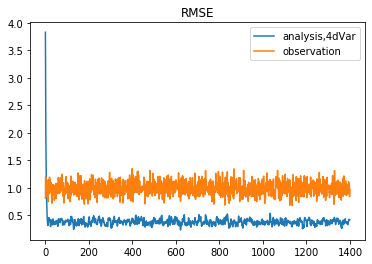

<Jmin> 28.613633138787023
[0, 3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39, 42, 45, 48, 51, 54, 57, 60, 63, 66, 69, 72, 75, 78, 81, 84, 87, 90, 93, 96, 99, 102, 105, 108, 111, 114, 117, 120, 123, 126, 129, 132, 135, 138, 141, 144, 147, 150, 153, 156, 159, 162, 165, 168, 171, 174, 177, 180, 183, 186, 189, 192, 195, 198, 201, 204, 207, 210, 213, 216, 219, 222, 225, 228, 231, 234, 237, 240, 243, 246, 249, 252, 255, 258, 261, 264, 267, 270, 273, 276, 279, 282, 285, 288, 291, 294, 297, 300, 303, 306, 309, 312, 315, 318, 321, 324, 327, 330, 333, 336, 339, 342, 345, 348, 351, 354, 357, 360, 363, 366, 369, 372, 375, 378, 381, 384, 387, 390, 393, 396, 399, 402, 405, 408, 411, 414, 417, 420, 423, 426, 429, 432, 435, 438, 441, 444, 447, 450, 453, 456, 459, 462, 465, 468, 471, 474, 477, 480, 483, 486, 489, 492, 495, 498, 501, 504, 507, 510, 513, 516, 519, 522, 525, 528, 531, 534, 537, 540, 543, 546, 549, 552, 555, 558, 561, 564, 567, 570, 573, 576, 579, 582, 585, 588, 591, 594, 597, 600, 603, 6

3 3
Optimization terminated successfully.
         Current function value: 46.756449
         Iterations: 17
         Function evaluations: 18
         Gradient evaluations: 18
31
(3, 40)
3 3
Optimization terminated successfully.
         Current function value: 47.655256
         Iterations: 16
         Function evaluations: 17
         Gradient evaluations: 17
32
(3, 40)
3 3
Optimization terminated successfully.
         Current function value: 44.848618
         Iterations: 15
         Function evaluations: 17
         Gradient evaluations: 17
33
(3, 40)
3 3
Optimization terminated successfully.
         Current function value: 45.706874
         Iterations: 14
         Function evaluations: 16
         Gradient evaluations: 16
34
(3, 40)
3 3
Optimization terminated successfully.
         Current function value: 48.769322
         Iterations: 15
         Function evaluations: 16
         Gradient evaluations: 16
35
(3, 40)
3 3
Optimization terminated successfully.
         Current f

3 3
Optimization terminated successfully.
         Current function value: 67.444305
         Iterations: 14
         Function evaluations: 15
         Gradient evaluations: 15
75
(3, 40)
3 3
Optimization terminated successfully.
         Current function value: 65.613380
         Iterations: 15
         Function evaluations: 16
         Gradient evaluations: 16
76
(3, 40)
3 3
Optimization terminated successfully.
         Current function value: 60.734966
         Iterations: 14
         Function evaluations: 15
         Gradient evaluations: 15
77
(3, 40)
3 3
Optimization terminated successfully.
         Current function value: 57.029453
         Iterations: 14
         Function evaluations: 15
         Gradient evaluations: 15
78
(3, 40)
3 3
Optimization terminated successfully.
         Current function value: 48.207393
         Iterations: 14
         Function evaluations: 15
         Gradient evaluations: 15
79
(3, 40)
3 3
Optimization terminated successfully.
         Current f

3 3
Optimization terminated successfully.
         Current function value: 53.301151
         Iterations: 14
         Function evaluations: 15
         Gradient evaluations: 15
119
(3, 40)
3 3
Optimization terminated successfully.
         Current function value: 50.772016
         Iterations: 16
         Function evaluations: 17
         Gradient evaluations: 17
120
(3, 40)
3 3
Optimization terminated successfully.
         Current function value: 49.394376
         Iterations: 15
         Function evaluations: 16
         Gradient evaluations: 16
121
(3, 40)
3 3
Optimization terminated successfully.
         Current function value: 50.059493
         Iterations: 15
         Function evaluations: 16
         Gradient evaluations: 16
122
(3, 40)
3 3
Optimization terminated successfully.
         Current function value: 53.030586
         Iterations: 14
         Function evaluations: 15
         Gradient evaluations: 15
123
(3, 40)
3 3
Optimization terminated successfully.
         Curr

3 3
Optimization terminated successfully.
         Current function value: 51.239812
         Iterations: 15
         Function evaluations: 16
         Gradient evaluations: 16
163
(3, 40)
3 3
Optimization terminated successfully.
         Current function value: 54.384535
         Iterations: 15
         Function evaluations: 16
         Gradient evaluations: 16
164
(3, 40)
3 3
Optimization terminated successfully.
         Current function value: 51.909340
         Iterations: 14
         Function evaluations: 15
         Gradient evaluations: 15
165
(3, 40)
3 3
Optimization terminated successfully.
         Current function value: 45.952410
         Iterations: 13
         Function evaluations: 14
         Gradient evaluations: 14
166
(3, 40)
3 3
Optimization terminated successfully.
         Current function value: 38.952791
         Iterations: 14
         Function evaluations: 15
         Gradient evaluations: 15
167
(3, 40)
3 3
Optimization terminated successfully.
         Curr

3 3
Optimization terminated successfully.
         Current function value: 58.587600
         Iterations: 15
         Function evaluations: 16
         Gradient evaluations: 16
207
(3, 40)
3 3
Optimization terminated successfully.
         Current function value: 58.181155
         Iterations: 14
         Function evaluations: 16
         Gradient evaluations: 16
208
(3, 40)
3 3
Optimization terminated successfully.
         Current function value: 57.238830
         Iterations: 16
         Function evaluations: 17
         Gradient evaluations: 17
209
(3, 40)
3 3
Optimization terminated successfully.
         Current function value: 62.170983
         Iterations: 16
         Function evaluations: 17
         Gradient evaluations: 17
210
(3, 40)
3 3
Optimization terminated successfully.
         Current function value: 67.819167
         Iterations: 17
         Function evaluations: 18
         Gradient evaluations: 18
211
(3, 40)
3 3
Optimization terminated successfully.
         Curr

3 3
Optimization terminated successfully.
         Current function value: 52.291444
         Iterations: 15
         Function evaluations: 17
         Gradient evaluations: 17
251
(3, 40)
3 3
Optimization terminated successfully.
         Current function value: 50.810772
         Iterations: 15
         Function evaluations: 16
         Gradient evaluations: 16
252
(3, 40)
3 3
Optimization terminated successfully.
         Current function value: 45.685357
         Iterations: 15
         Function evaluations: 16
         Gradient evaluations: 16
253
(3, 40)
3 3
Optimization terminated successfully.
         Current function value: 47.947109
         Iterations: 15
         Function evaluations: 17
         Gradient evaluations: 17
254
(3, 40)
3 3
Optimization terminated successfully.
         Current function value: 52.765928
         Iterations: 15
         Function evaluations: 16
         Gradient evaluations: 16
255
(3, 40)
3 3
Optimization terminated successfully.
         Curr

3 3
Optimization terminated successfully.
         Current function value: 55.894459
         Iterations: 16
         Function evaluations: 17
         Gradient evaluations: 17
295
(3, 40)
3 3
Optimization terminated successfully.
         Current function value: 52.047173
         Iterations: 15
         Function evaluations: 16
         Gradient evaluations: 16
296
(3, 40)
3 3
Optimization terminated successfully.
         Current function value: 51.556676
         Iterations: 15
         Function evaluations: 16
         Gradient evaluations: 16
297
(3, 40)
3 3
Optimization terminated successfully.
         Current function value: 52.677636
         Iterations: 15
         Function evaluations: 16
         Gradient evaluations: 16
298
(3, 40)
3 3
Optimization terminated successfully.
         Current function value: 55.492587
         Iterations: 13
         Function evaluations: 15
         Gradient evaluations: 15
299
(3, 40)
3 3
Optimization terminated successfully.
         Curr

3 3
Optimization terminated successfully.
         Current function value: 53.780570
         Iterations: 15
         Function evaluations: 17
         Gradient evaluations: 17
339
(3, 40)
3 3
Optimization terminated successfully.
         Current function value: 54.402887
         Iterations: 14
         Function evaluations: 16
         Gradient evaluations: 16
340
(3, 40)
3 3
Optimization terminated successfully.
         Current function value: 45.967972
         Iterations: 17
         Function evaluations: 18
         Gradient evaluations: 18
341
(3, 40)
3 3
Optimization terminated successfully.
         Current function value: 51.551103
         Iterations: 14
         Function evaluations: 16
         Gradient evaluations: 16
342
(3, 40)
3 3
Optimization terminated successfully.
         Current function value: 57.130038
         Iterations: 14
         Function evaluations: 16
         Gradient evaluations: 16
343
(3, 40)
3 3
Optimization terminated successfully.
         Curr

3 3
Optimization terminated successfully.
         Current function value: 55.875823
         Iterations: 14
         Function evaluations: 15
         Gradient evaluations: 15
383
(3, 40)
3 3
Optimization terminated successfully.
         Current function value: 48.562664
         Iterations: 15
         Function evaluations: 17
         Gradient evaluations: 17
384
(3, 40)
3 3
Optimization terminated successfully.
         Current function value: 62.897984
         Iterations: 18
         Function evaluations: 19
         Gradient evaluations: 19
385
(3, 40)
3 3
Optimization terminated successfully.
         Current function value: 51.590106
         Iterations: 16
         Function evaluations: 17
         Gradient evaluations: 17
386
(3, 40)
3 3
Optimization terminated successfully.
         Current function value: 51.558280
         Iterations: 16
         Function evaluations: 17
         Gradient evaluations: 17
387
(3, 40)
3 3
Optimization terminated successfully.
         Curr

3 3
Optimization terminated successfully.
         Current function value: 61.726412
         Iterations: 17
         Function evaluations: 18
         Gradient evaluations: 18
427
(3, 40)
3 3
Optimization terminated successfully.
         Current function value: 54.119509
         Iterations: 15
         Function evaluations: 17
         Gradient evaluations: 17
428
(3, 40)
3 3
Optimization terminated successfully.
         Current function value: 52.181319
         Iterations: 17
         Function evaluations: 18
         Gradient evaluations: 18
429
(3, 40)
3 3
Optimization terminated successfully.
         Current function value: 46.549575
         Iterations: 15
         Function evaluations: 16
         Gradient evaluations: 16
430
(3, 40)
3 3
Optimization terminated successfully.
         Current function value: 51.656606
         Iterations: 14
         Function evaluations: 16
         Gradient evaluations: 16
431
(3, 40)
3 3
Optimization terminated successfully.
         Curr

3 3
Optimization terminated successfully.
         Current function value: 45.290113
         Iterations: 14
         Function evaluations: 15
         Gradient evaluations: 15
471
(3, 40)
3 3
Optimization terminated successfully.
         Current function value: 46.827716
         Iterations: 13
         Function evaluations: 15
         Gradient evaluations: 15
472
(3, 40)
3 3
Optimization terminated successfully.
         Current function value: 39.187162
         Iterations: 15
         Function evaluations: 16
         Gradient evaluations: 16
473
(3, 40)
3 3
Optimization terminated successfully.
         Current function value: 42.658544
         Iterations: 14
         Function evaluations: 15
         Gradient evaluations: 15
474
(3, 40)
3 3
Optimization terminated successfully.
         Current function value: 39.805383
         Iterations: 14
         Function evaluations: 15
         Gradient evaluations: 15
475
(3, 40)
3 3
Optimization terminated successfully.
         Curr

3 3
Optimization terminated successfully.
         Current function value: 56.156124
         Iterations: 16
         Function evaluations: 17
         Gradient evaluations: 17
515
(3, 40)
3 3
Optimization terminated successfully.
         Current function value: 54.280321
         Iterations: 16
         Function evaluations: 17
         Gradient evaluations: 17
516
(3, 40)
3 3
Optimization terminated successfully.
         Current function value: 51.539697
         Iterations: 14
         Function evaluations: 16
         Gradient evaluations: 16
517
(3, 40)
3 3
Optimization terminated successfully.
         Current function value: 49.085578
         Iterations: 16
         Function evaluations: 17
         Gradient evaluations: 17
518
(3, 40)
3 3
Optimization terminated successfully.
         Current function value: 59.653786
         Iterations: 17
         Function evaluations: 18
         Gradient evaluations: 18
519
(3, 40)
3 3
Optimization terminated successfully.
         Curr

3 3
Optimization terminated successfully.
         Current function value: 66.529115
         Iterations: 16
         Function evaluations: 17
         Gradient evaluations: 17
559
(3, 40)
3 3
Optimization terminated successfully.
         Current function value: 58.105807
         Iterations: 16
         Function evaluations: 17
         Gradient evaluations: 17
560
(3, 40)
3 3
Optimization terminated successfully.
         Current function value: 50.107394
         Iterations: 16
         Function evaluations: 18
         Gradient evaluations: 18
561
(3, 40)
3 3
Optimization terminated successfully.
         Current function value: 49.856885
         Iterations: 17
         Function evaluations: 18
         Gradient evaluations: 18
562
(3, 40)
3 3
Optimization terminated successfully.
         Current function value: 55.530560
         Iterations: 18
         Function evaluations: 19
         Gradient evaluations: 19
563
(3, 40)
3 3
Optimization terminated successfully.
         Curr

3 3
Optimization terminated successfully.
         Current function value: 55.010253
         Iterations: 17
         Function evaluations: 18
         Gradient evaluations: 18
603
(3, 40)
3 3
Optimization terminated successfully.
         Current function value: 49.822155
         Iterations: 16
         Function evaluations: 17
         Gradient evaluations: 17
604
(3, 40)
3 3
Optimization terminated successfully.
         Current function value: 58.014087
         Iterations: 16
         Function evaluations: 17
         Gradient evaluations: 17
605
(3, 40)
3 3
Optimization terminated successfully.
         Current function value: 57.479033
         Iterations: 16
         Function evaluations: 17
         Gradient evaluations: 17
606
(3, 40)
3 3
Optimization terminated successfully.
         Current function value: 54.916840
         Iterations: 18
         Function evaluations: 19
         Gradient evaluations: 19
607
(3, 40)
3 3
Optimization terminated successfully.
         Curr

3 3
Optimization terminated successfully.
         Current function value: 51.854398
         Iterations: 16
         Function evaluations: 17
         Gradient evaluations: 17
647
(3, 40)
3 3
Optimization terminated successfully.
         Current function value: 52.587985
         Iterations: 16
         Function evaluations: 17
         Gradient evaluations: 17
648
(3, 40)
3 3
Optimization terminated successfully.
         Current function value: 53.973723
         Iterations: 15
         Function evaluations: 16
         Gradient evaluations: 16
649
(3, 40)
3 3
Optimization terminated successfully.
         Current function value: 52.280744
         Iterations: 17
         Function evaluations: 18
         Gradient evaluations: 18
650
(3, 40)
3 3
Optimization terminated successfully.
         Current function value: 47.533704
         Iterations: 14
         Function evaluations: 16
         Gradient evaluations: 16
651
(3, 40)
3 3
Optimization terminated successfully.
         Curr

3 3
Optimization terminated successfully.
         Current function value: 48.888897
         Iterations: 15
         Function evaluations: 16
         Gradient evaluations: 16
691
(3, 40)
3 3
Optimization terminated successfully.
         Current function value: 53.752366
         Iterations: 14
         Function evaluations: 16
         Gradient evaluations: 16
692
(3, 40)
3 3
Optimization terminated successfully.
         Current function value: 47.218055
         Iterations: 14
         Function evaluations: 15
         Gradient evaluations: 15
693
(3, 40)
3 3
Optimization terminated successfully.
         Current function value: 44.416310
         Iterations: 16
         Function evaluations: 17
         Gradient evaluations: 17
694
(3, 40)
3 3
Optimization terminated successfully.
         Current function value: 43.326404
         Iterations: 14
         Function evaluations: 16
         Gradient evaluations: 16
695
(3, 40)
3 3
Optimization terminated successfully.
         Curr

3 3
Optimization terminated successfully.
         Current function value: 56.463625
         Iterations: 15
         Function evaluations: 16
         Gradient evaluations: 16
735
(3, 40)
3 3
Optimization terminated successfully.
         Current function value: 64.923901
         Iterations: 14
         Function evaluations: 16
         Gradient evaluations: 16
736
(3, 40)
3 3
Optimization terminated successfully.
         Current function value: 63.165026
         Iterations: 16
         Function evaluations: 18
         Gradient evaluations: 18
737
(3, 40)
3 3
Optimization terminated successfully.
         Current function value: 58.069933
         Iterations: 15
         Function evaluations: 17
         Gradient evaluations: 17
738
(3, 40)
3 3
Optimization terminated successfully.
         Current function value: 61.549872
         Iterations: 16
         Function evaluations: 17
         Gradient evaluations: 17
739
(3, 40)
3 3
Optimization terminated successfully.
         Curr

3 3
Optimization terminated successfully.
         Current function value: 43.997872
         Iterations: 15
         Function evaluations: 16
         Gradient evaluations: 16
779
(3, 40)
3 3
Optimization terminated successfully.
         Current function value: 51.997132
         Iterations: 14
         Function evaluations: 16
         Gradient evaluations: 16
780
(3, 40)
3 3
Optimization terminated successfully.
         Current function value: 71.400287
         Iterations: 14
         Function evaluations: 16
         Gradient evaluations: 16
781
(3, 40)
3 3
Optimization terminated successfully.
         Current function value: 65.427175
         Iterations: 16
         Function evaluations: 17
         Gradient evaluations: 17
782
(3, 40)
3 3
Optimization terminated successfully.
         Current function value: 55.597723
         Iterations: 14
         Function evaluations: 16
         Gradient evaluations: 16
783
(3, 40)
3 3
Optimization terminated successfully.
         Curr

(3, 40)
3 3
Optimization terminated successfully.
         Current function value: 52.125938
         Iterations: 14
         Function evaluations: 15
         Gradient evaluations: 15
824
(3, 40)
3 3
Optimization terminated successfully.
         Current function value: 55.432175
         Iterations: 14
         Function evaluations: 15
         Gradient evaluations: 15
825
(3, 40)
3 3
Optimization terminated successfully.
         Current function value: 61.320942
         Iterations: 13
         Function evaluations: 14
         Gradient evaluations: 14
826
(3, 40)
3 3
Optimization terminated successfully.
         Current function value: 48.422087
         Iterations: 13
         Function evaluations: 14
         Gradient evaluations: 14
827
(3, 40)
3 3
Optimization terminated successfully.
         Current function value: 38.562725
         Iterations: 13
         Function evaluations: 14
         Gradient evaluations: 14
828
(3, 40)
3 3
Optimization terminated successfully.
     

3 3
Optimization terminated successfully.
         Current function value: 44.815873
         Iterations: 15
         Function evaluations: 17
         Gradient evaluations: 17
868
(3, 40)
3 3
Optimization terminated successfully.
         Current function value: 51.305877
         Iterations: 17
         Function evaluations: 18
         Gradient evaluations: 18
869
(3, 40)
3 3
Optimization terminated successfully.
         Current function value: 58.480535
         Iterations: 17
         Function evaluations: 18
         Gradient evaluations: 18
870
(3, 40)
3 3
Optimization terminated successfully.
         Current function value: 58.078646
         Iterations: 15
         Function evaluations: 17
         Gradient evaluations: 17
871
(3, 40)
3 3
Optimization terminated successfully.
         Current function value: 59.908388
         Iterations: 17
         Function evaluations: 18
         Gradient evaluations: 18
872
(3, 40)
3 3
Optimization terminated successfully.
         Curr

3 3
Optimization terminated successfully.
         Current function value: 43.803936
         Iterations: 17
         Function evaluations: 18
         Gradient evaluations: 18
912
(3, 40)
3 3
Optimization terminated successfully.
         Current function value: 45.133739
         Iterations: 14
         Function evaluations: 16
         Gradient evaluations: 16
913
(3, 40)
3 3
Optimization terminated successfully.
         Current function value: 44.828294
         Iterations: 14
         Function evaluations: 16
         Gradient evaluations: 16
914
(3, 40)
3 3
Optimization terminated successfully.
         Current function value: 46.961007
         Iterations: 17
         Function evaluations: 18
         Gradient evaluations: 18
915
(3, 40)
3 3
Optimization terminated successfully.
         Current function value: 50.818034
         Iterations: 16
         Function evaluations: 17
         Gradient evaluations: 17
916
(3, 40)
3 3
Optimization terminated successfully.
         Curr

3 3
Optimization terminated successfully.
         Current function value: 49.122598
         Iterations: 15
         Function evaluations: 16
         Gradient evaluations: 16
956
(3, 40)
3 3
Optimization terminated successfully.
         Current function value: 52.029591
         Iterations: 15
         Function evaluations: 16
         Gradient evaluations: 16
957
(3, 40)
3 3
Optimization terminated successfully.
         Current function value: 48.101126
         Iterations: 16
         Function evaluations: 17
         Gradient evaluations: 17
958
(3, 40)
3 3
Optimization terminated successfully.
         Current function value: 49.705589
         Iterations: 15
         Function evaluations: 17
         Gradient evaluations: 17
959
(3, 40)
3 3
Optimization terminated successfully.
         Current function value: 54.340057
         Iterations: 14
         Function evaluations: 16
         Gradient evaluations: 16
960
(3, 40)
3 3
Optimization terminated successfully.
         Curr

3 3
Optimization terminated successfully.
         Current function value: 58.006825
         Iterations: 16
         Function evaluations: 17
         Gradient evaluations: 17
1000
(3, 40)
3 3
Optimization terminated successfully.
         Current function value: 62.674705
         Iterations: 16
         Function evaluations: 17
         Gradient evaluations: 17
1001
(3, 40)
3 3
Optimization terminated successfully.
         Current function value: 60.168102
         Iterations: 16
         Function evaluations: 17
         Gradient evaluations: 17
1002
(3, 40)
3 3
Optimization terminated successfully.
         Current function value: 51.207114
         Iterations: 17
         Function evaluations: 18
         Gradient evaluations: 18
1003
(3, 40)
3 3
Optimization terminated successfully.
         Current function value: 45.585720
         Iterations: 16
         Function evaluations: 18
         Gradient evaluations: 18
1004
(3, 40)
3 3
Optimization terminated successfully.
        

3 3
Optimization terminated successfully.
         Current function value: 51.430518
         Iterations: 16
         Function evaluations: 17
         Gradient evaluations: 17
1044
(3, 40)
3 3
Optimization terminated successfully.
         Current function value: 42.338509
         Iterations: 14
         Function evaluations: 15
         Gradient evaluations: 15
1045
(3, 40)
3 3
Optimization terminated successfully.
         Current function value: 46.236502
         Iterations: 14
         Function evaluations: 16
         Gradient evaluations: 16
1046
(3, 40)
3 3
Optimization terminated successfully.
         Current function value: 46.456447
         Iterations: 15
         Function evaluations: 16
         Gradient evaluations: 16
1047
(3, 40)
3 3
Optimization terminated successfully.
         Current function value: 52.669763
         Iterations: 14
         Function evaluations: 16
         Gradient evaluations: 16
1048
(3, 40)
3 3
Optimization terminated successfully.
        

3 3
Optimization terminated successfully.
         Current function value: 57.677054
         Iterations: 16
         Function evaluations: 17
         Gradient evaluations: 17
1088
(3, 40)
3 3
Optimization terminated successfully.
         Current function value: 56.519152
         Iterations: 18
         Function evaluations: 19
         Gradient evaluations: 19
1089
(3, 40)
3 3
Optimization terminated successfully.
         Current function value: 64.554296
         Iterations: 18
         Function evaluations: 19
         Gradient evaluations: 19
1090
(3, 40)
3 3
Optimization terminated successfully.
         Current function value: 53.053013
         Iterations: 16
         Function evaluations: 17
         Gradient evaluations: 17
1091
(3, 40)
3 3
Optimization terminated successfully.
         Current function value: 55.889851
         Iterations: 15
         Function evaluations: 17
         Gradient evaluations: 17
1092
(3, 40)
3 3
Optimization terminated successfully.
        

3 3
Optimization terminated successfully.
         Current function value: 26.615389
         Iterations: 15
         Function evaluations: 16
         Gradient evaluations: 16
1132
(3, 40)
3 3
Optimization terminated successfully.
         Current function value: 34.440445
         Iterations: 15
         Function evaluations: 16
         Gradient evaluations: 16
1133
(3, 40)
3 3
Optimization terminated successfully.
         Current function value: 39.663041
         Iterations: 15
         Function evaluations: 16
         Gradient evaluations: 16
1134
(3, 40)
3 3
Optimization terminated successfully.
         Current function value: 45.103897
         Iterations: 14
         Function evaluations: 15
         Gradient evaluations: 15
1135
(3, 40)
3 3
Optimization terminated successfully.
         Current function value: 57.062675
         Iterations: 16
         Function evaluations: 17
         Gradient evaluations: 17
1136
(3, 40)
3 3
Optimization terminated successfully.
        

3 3
Optimization terminated successfully.
         Current function value: 48.358865
         Iterations: 17
         Function evaluations: 18
         Gradient evaluations: 18
1176
(3, 40)
3 3
Optimization terminated successfully.
         Current function value: 41.927727
         Iterations: 14
         Function evaluations: 16
         Gradient evaluations: 16
1177
(3, 40)
3 3
Optimization terminated successfully.
         Current function value: 45.174927
         Iterations: 15
         Function evaluations: 16
         Gradient evaluations: 16
1178
(3, 40)
3 3
Optimization terminated successfully.
         Current function value: 44.302553
         Iterations: 13
         Function evaluations: 15
         Gradient evaluations: 15
1179
(3, 40)
3 3
Optimization terminated successfully.
         Current function value: 56.942249
         Iterations: 14
         Function evaluations: 15
         Gradient evaluations: 15
1180
(3, 40)
3 3
Optimization terminated successfully.
        

3 3
Optimization terminated successfully.
         Current function value: 46.552569
         Iterations: 14
         Function evaluations: 16
         Gradient evaluations: 16
1220
(3, 40)
3 3
Optimization terminated successfully.
         Current function value: 54.222280
         Iterations: 14
         Function evaluations: 16
         Gradient evaluations: 16
1221
(3, 40)
3 3
Optimization terminated successfully.
         Current function value: 51.664287
         Iterations: 15
         Function evaluations: 16
         Gradient evaluations: 16
1222
(3, 40)
3 3
Optimization terminated successfully.
         Current function value: 54.768046
         Iterations: 14
         Function evaluations: 16
         Gradient evaluations: 16
1223
(3, 40)
3 3
Optimization terminated successfully.
         Current function value: 55.724354
         Iterations: 16
         Function evaluations: 17
         Gradient evaluations: 17
1224
(3, 40)
3 3
Optimization terminated successfully.
        

3 3
Optimization terminated successfully.
         Current function value: 54.601821
         Iterations: 14
         Function evaluations: 15
         Gradient evaluations: 15
1264
(3, 40)
3 3
Optimization terminated successfully.
         Current function value: 51.422534
         Iterations: 15
         Function evaluations: 17
         Gradient evaluations: 17
1265
(3, 40)
3 3
Optimization terminated successfully.
         Current function value: 51.547544
         Iterations: 17
         Function evaluations: 18
         Gradient evaluations: 18
1266
(3, 40)
3 3
Optimization terminated successfully.
         Current function value: 53.640471
         Iterations: 15
         Function evaluations: 17
         Gradient evaluations: 17
1267
(3, 40)
3 3
Optimization terminated successfully.
         Current function value: 48.711920
         Iterations: 14
         Function evaluations: 16
         Gradient evaluations: 16
1268
(3, 40)
3 3
Optimization terminated successfully.
        

3 3
Optimization terminated successfully.
         Current function value: 44.769678
         Iterations: 16
         Function evaluations: 17
         Gradient evaluations: 17
1308
(3, 40)
3 3
Optimization terminated successfully.
         Current function value: 46.369227
         Iterations: 15
         Function evaluations: 17
         Gradient evaluations: 17
1309
(3, 40)
3 3
Optimization terminated successfully.
         Current function value: 44.420357
         Iterations: 16
         Function evaluations: 17
         Gradient evaluations: 17
1310
(3, 40)
3 3
Optimization terminated successfully.
         Current function value: 40.296983
         Iterations: 18
         Function evaluations: 19
         Gradient evaluations: 19
1311
(3, 40)
3 3
Optimization terminated successfully.
         Current function value: 41.957080
         Iterations: 15
         Function evaluations: 16
         Gradient evaluations: 16
1312
(3, 40)
3 3
Optimization terminated successfully.
        

3 3
Optimization terminated successfully.
         Current function value: 55.618918
         Iterations: 14
         Function evaluations: 16
         Gradient evaluations: 16
1352
(3, 40)
3 3
Optimization terminated successfully.
         Current function value: 59.035075
         Iterations: 16
         Function evaluations: 17
         Gradient evaluations: 17
1353
(3, 40)
3 3
Optimization terminated successfully.
         Current function value: 46.340959
         Iterations: 17
         Function evaluations: 18
         Gradient evaluations: 18
1354
(3, 40)
3 3
Optimization terminated successfully.
         Current function value: 43.965333
         Iterations: 17
         Function evaluations: 18
         Gradient evaluations: 18
1355
(3, 40)
3 3
Optimization terminated successfully.
         Current function value: 42.968134
         Iterations: 14
         Function evaluations: 15
         Gradient evaluations: 15
1356
(3, 40)
3 3
Optimization terminated successfully.
        

3 3
Optimization terminated successfully.
         Current function value: 43.043082
         Iterations: 15
         Function evaluations: 16
         Gradient evaluations: 16
1396
(3, 40)
3 3
Optimization terminated successfully.
         Current function value: 42.635596
         Iterations: 15
         Function evaluations: 16
         Gradient evaluations: 16
1397
(3, 40)
3 3
Optimization terminated successfully.
         Current function value: 42.338233
         Iterations: 16
         Function evaluations: 18
         Gradient evaluations: 18
1398
(3, 40)
3 3
Optimization terminated successfully.
         Current function value: 57.434211
         Iterations: 14
         Function evaluations: 16
         Gradient evaluations: 16
1399
elapsed_time:314.1048266887665[sec]
(4200,)


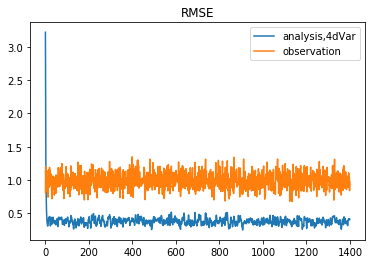

<Jmin> 36.418565696986995


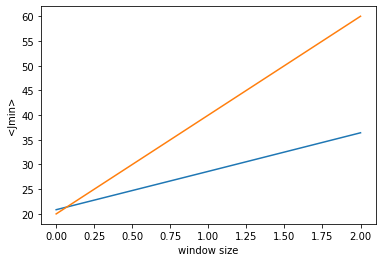

In [9]:
import time
t = 1400
N = 40
h = 0.05 
F = 8.0

dataset = pd.read_csv("observation_data.csv")
y = dataset.values
y = y.reshape(1460,N)
dataset2 = pd.read_csv("data.csv")
Xt = dataset2.values.reshape(1460,N)

#print(Xa)
#print(B)
#X.append(Xa
RMSE=[]
Jmin_=[]
TLM=[]
A=[]
Jmin=[]
for a_window in range(3):
    start = time.time()
    X = []

    #初期値
    Xa = np.random.randn(N)
    X0 = Xa
    for j in range(500):
        Xa = Rungekutta4(X0,h,F)
        X0 = Xa
    #X.append(Xa)
    
    B = np.eye(N) * 0.2
    
    Time=range(0,t,a_window+1)
    print(list(Time))
    
    for k in range(t):
        (Xf,B) = Forecast(Xa,B)
        obs = y[k:k+a_window+1,:]
        print(obs.shape)
        (Xa,M,MT,jmin) = Analysis(Xf,B,obs,a_window)
        X.append(Xa)
        TLM.append(M)
        Jmin.append(jmin)
        #for l in range(a_window):
        #    Xb = Rungekutta4(Xa,h,F)
        #    X.append(Xb)
        #    Xa = Xb
        #if(k%100==0):
        print(k)

    elapsed_time = time.time()-start
    print("elapsed_time:{0}".format(elapsed_time) + "[sec]")
    print(np.array(TLM).shape)

    #XA = np.array(X)
#print(Xa)

    C1_ = []
    C2_ = []
    H = np.eye(N)
#H2 = H/2 + np.roll(H,1,axis=1)/2
    for i in range(t):
        X1 = X[i]
        X2 = Xt[i]
        X3 = sum((X2-X1)*(X2-X1))/N
        Y1 = y[i]
    #mask = Y1>=0
    #Y1 = Y1[mask]
    #e = np.eye(N)
    #p = int(np.sum(e[mask]))
        Y2 = sum((H@X2-Y1)*(H@X2-Y1))/N
    #Y2 = sum((H3(X2,mask)-Y1)*(H3(X2,mask)-Y1))/p
        rmse1 = np.sqrt(X3)
        rmse2 = np.sqrt(Y2)
        C1_.append(rmse1)
        C2_.append(rmse2)
    #plt.plot(C1,label="analysis,OI")
    plt.plot(C1_,label="analysis,4dVar")
    plt.plot(C2_,label="observation")
#plt.plot(errcov,label="Pa")
    plt.legend()
    plt.title("RMSE")
    #plt.savefig("4dVar_window"+str(a_window)+"2.jpg")
    plt.show()
    print("<Jmin>",np.mean(np.array(Jmin)))
    
    #r=np.mean(np.array(C1_[500:]))
    r=np.mean(np.array(Jmin))
    RMSE.append(r)
    Jmin_.append(N*(a_window+1)/2)
    A.append(a_window)
    
plt.plot(A,RMSE)
plt.plot(A,Jmin_)
plt.xlabel("window size")
plt.ylabel("<Jmin>")
#plt.savefig("4dVar_windowsize2.jpg")
plt.show()

[ 20.  40.  60.  80. 100. 120. 140. 160. 180. 200.]


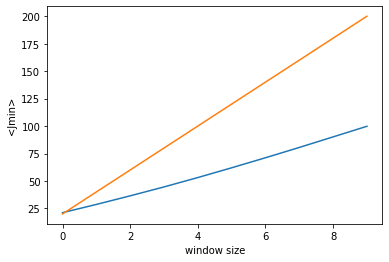

In [8]:
awin = np.array(A)
jmin = (N + awin*N)/2
print(jmin)
plt.plot(A,RMSE)
plt.plot(A,jmin)
plt.xlabel("window size")
plt.ylabel("<Jmin>")
#plt.savefig("4dVar_windowsize2.jpg")
plt.show()

In [11]:
#4dVar with scipy.optimize (modified)

def H3(X,mask):
    X_=X[mask]
    return np.sqrt(X_*X_)
def H3_t(X,dX,mask):
    H = np.diag(np.sqrt(X*X)/X)
    Ht = H[mask]
    return Ht@dX
def H3_adj(X,dY,mask):
    H = np.diag(np.sqrt(X*X)/X)
    Hadj = H[mask].T
    return Hadj@dY

def Forecast(Xa,B):
    
    Xf = Rungekutta4(Xa,h,F)
   
    #M = get_linear(Xa,h,F,N)
    #Pf = M @ Pa @ M.T #カルマンフィルターでは時間発展する、3次元変分法では定数
    Pf = B
    
    return Xf,Pf

def Analysis(Xf,B,y,a_window):
    from scipy import optimize
    
    H = np.eye(N)
    #H2 = H/2 + np.roll(H,1,axis=1)/2
    #mask = y>=0
    #y_ = y[mask]
    #e = np.ones(N)
    #p = int(np.sum(e[mask]))
    #R = np.eye(p)
    """Ex = np.eye(N)
    Ey = np.eye(p)
    H3t=np.zeros((N,p))
    H3adj=np.zeros((p,N))
    for i in range(N):
        H3t[i] = H3_t(Xf,Ex[i],mask)
    for i in range(p):
        H3adj[i] = H3_adj(Xf,Ey[i],mask)
    H3t = H3t.T
    H3adj = H3adj.T
    #print(H3t,H3adj)"""
    R = np.eye(N)
    E = np.eye(N)
    
    R_inv=np.linalg.inv(R)
    B_inv=np.linalg.inv(B)
      
    Fcst = [] #基本場
    xb = Xf
    Fcst.append(xb)
    for k in range(a_window):
        Xf_ = Rungekutta4(xb,h,F)
        Fcst.append(Xf_)
        xb = Xf_
        
    #M = [] #TLM
    #Mk = np.eye(N)
    #M.append(Mk)
    #MT = [] #ADM
    #MkT = np.eye(N)
    #MT.append(MkT)
    #for k in range(a_window):
    #    xk = Fcst[k].reshape(-1,1)
    #    Mk_ = Rungekutta4_t(xk,E,h,F)
    #    MkT_ = Rungekutta4_adj(E,xk,h,F)
    #    Mk = Mk_@M[k]
    #    MkT = MT[k]@MkT_
    #    M.append(Mk)
    #    MT.append(MkT)
    #print(len(M),len(MT))
    
    U = np.linalg.cholesky(B)
    dv0 = np.zeros(N)
    args=(U,R_inv,H,y,Fcst,a_window)
    res = optimize.minimize(J, dv0, args=args, method='BFGS', jac=jacobi, options={'gtol':1e-6, 'disp':True})
    dv = res.x
    jmin = res.fun
    #dv = optimize.fmin_cg(J,dv0,fprime=jacobi,args=args)
    #dv = CG(dv0,U,R_inv,H,y,Fcst,M,MT,a_window)
    X = U@dv
    Xa = X + Xf
    
    return Xa,jmin

def J(dv,*args):
    U,R_inv,H,y,Fcst,a_window = args
    xk = Fcst[0]
    yk = y[0]
    dk = yk-H@xk    
    dxk = U@dv
    j = (H@dxk-dk).T@R_inv@(H@dxk-dk)/2
    for k in range(1,a_window+1):
        xk = Fcst[k]
        yk = y[k]
        dk = yk-H@xk
        Mxk = Rungekutta4_t(Fcst[k-1],dxk,h,F)
        j += (H@Mxk-dk).T@R_inv@(H@Mxk-dk)/2
        dxk = Mxk
    return j+dv.T@dv/2

def jacobi(dv,*args):
    U,R_inv,H,y,Fcst,a_window = args
    
    #increment
    xk = Fcst[0]
    yk = y[0]
    dk = yk-H@xk
    dxk = U@dv
    dt = []
    dt.append(H.T@R_inv@(H@U@dxk-dk))
    for k in range(1,a_window+1):
        xk = Fcst[k]
        yk = y[k]
        dk = yk-H@xk
        Mxk = Rungekutta4_t(Fcst[k-1],dxk,h,F)
        dt.append(H.T@R_inv@(H@Mxk-dk))
        dxk = Mxk
        
    for k in range(a_window,0,-1):
        MkTx = Rungekutta4_adj(dt[k],Fcst[k-1],h,F)
        dt[k-1] += MkTx
    p = U.T@dt[0]
         
    return p+dv


In [12]:
import time
t = 1400
N = 40
h = 0.05 
F = 8.0

dataset = pd.read_csv("observation_data.csv")
y = dataset.values
y = y.reshape(1460,N)
dataset2 = pd.read_csv("data.csv")
Xt = dataset2.values.reshape(1460,N)

#print(Xa)
#print(B)
#X.append(Xa
RMSE=[]
Jmin_=[]
A=[]
Jmin = []
for j in range(5):
    start = time.time()
    X = []

    #初期値
    Xa = np.random.randn(N)
    X0 = Xa
    for j in range(500):
        Xa = Rungekutta4(X0,h,F)
        X0 = Xa
    #X.append(Xa)
    
    B = np.eye(N) * 0.2
    
    a_window = j

    Time=range(0,t,a_window+1)
    print(list(Time))
    
    for k in range(t):
        (Xf,B) = Forecast(Xa,B)
        obs = y[k:k+a_window+1,:]
        print(obs.shape)
        (Xa,jmin) = Analysis(Xf,B,obs,a_window)
        X.append(Xa)
        Jmin.append(jmin)
        #for l in range(a_window):
        #    Xb = Rungekutta4(Xa,h,F)
        #    X.append(Xb)
        #    Xa = Xb
        #if(k%100==0):
        print(k)

    elapsed_time = time.time()-start
    print("elapsed_time:{0}".format(elapsed_time) + "[sec]")
    
    #XA = np.array(X)
#print(Xa)

    C1_ = []
    C2_ = []
    H = np.eye(N)
#H2 = H/2 + np.roll(H,1,axis=1)/2
    for i in range(t):
        X1 = X[i]
        X2 = Xt[i]
        X3 = sum((X2-X1)*(X2-X1))/N
        Y1 = y[i]
    #mask = Y1>=0
    #Y1 = Y1[mask]
    #e = np.eye(N)
    #p = int(np.sum(e[mask]))
        Y2 = sum((H@X2-Y1)*(H@X2-Y1))/N
    #Y2 = sum((H3(X2,mask)-Y1)*(H3(X2,mask)-Y1))/p
        rmse1 = np.sqrt(X3)
        rmse2 = np.sqrt(Y2)
        C1_.append(rmse1)
        C2_.append(rmse2)
    #plt.plot(C1,label="analysis,OI")
    plt.plot(C1_,label="analysis,4dVar")
    plt.plot(C2_,label="observation")
#plt.plot(errcov,label="Pa")
    plt.legend()
    plt.title("RMSE")
    #plt.savefig("4dVar_window"+str(a_window)+"2.jpg")
    plt.show()
    
    print("<Jmin>",np.mean(np.array(Jmin)))
    
    r=np.mean(np.mean(np.array(Jmin)))
    #r=np.mean(np.array(C1_[500:]))
    RMSE.append(r)
    Jmin_.append(N*(a_window+1)/2)
    A.append(a_window)
    
plt.plot(A,RMSE)
plt.plot(A,Jmin_)
plt.xlabel("window size")
plt.ylabel("<Jmin>")
#plt.savefig("4dVar_windowsize2.jpg")
plt.show()

[0, 500, 1000]
(500, 40)
         Current function value: 292993.350754
         Iterations: 0
         Function evaluations: 16
         Gradient evaluations: 4
0
(500, 40)


KeyboardInterrupt: 

[[-0.2490739   0.26989896  0.50578661  0.97135867  0.81686492  0.40700197
   0.12760711  0.48990083  0.3026442   0.91075039  0.47250591  0.28259798
   0.07476412  0.04629482  0.2196689   0.92943035  0.37801589  0.12539999
   0.16927817  0.14645487  0.05246     0.38869726 -0.24413971  0.10531986
   0.75822953  0.65544506  0.61397899  0.1633552   0.14306171  0.96627184
   0.61604561 -0.03622691  0.04854172  0.77361565  0.76574603  0.27266244
   0.38581968  0.07764816  0.73006815  0.52939852]
 [-0.03401109  0.44370328  0.85666145  0.75606736  0.51148573  0.39344289
   0.15749347  0.57789142  0.86096394  0.93417832  0.59384009  0.12757904
  -0.00878752  0.35628189  0.8606473   0.75982662  0.23612793  0.10603619
   0.33481025  0.84024683  0.52519634  0.02445413  0.13365885  0.5961995
   0.6455037   0.37379898  0.32298819  0.37068961  0.48440491  1.18734592
   0.58382663 -0.09309223  0.03537159  0.57914341  0.82400864  0.37915709
   0.68164593  0.85703109  0.80149755  0.45298597]
 [ 0.027930

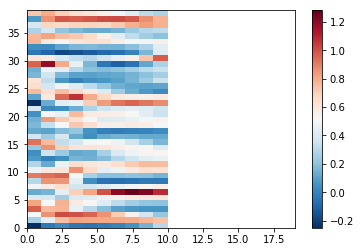

In [13]:
trM=[]
for k in range(len(TLM)):
    trM.append(np.diag(np.mean(np.array(TLM)[k,:,:,:], axis=0)))
diagM = np.array(trM).reshape(len(TLM),-1)
print(diagM[:])
ts = np.arange(len(TLM))
xs = np.arange(N)
plt.pcolor(ts,xs,diagM.T,cmap='RdBu_r')
plt.colorbar()
plt.show()

In [15]:
print(X[:20]-y[:20])

[[ 7.92929388e+000  5.08411804e+000 -3.69917445e+000  1.06605417e+000
  -3.70040006e+000 -7.50378332e-001  6.11758374e+000 -2.84203252e-001
  -9.13915904e+000 -1.42506114e-001  9.58548774e-001 -1.48447812e+000
  -9.68791380e-001  8.89850197e+000 -4.38426206e+000  1.54270243e-001
  -1.66187314e+000  9.99836845e-001  5.89353307e-001 -2.89402891e+000
  -5.23348204e+000 -2.58121618e+000  4.39086614e+000  2.81050916e-001
  -2.58228897e+000 -2.09639259e+000  2.21152265e+000 -6.95812266e-001
   7.87457388e-001  1.28535581e+000  3.34091384e+000 -4.71217255e+000
  -2.11744201e+000 -1.60977195e+000 -3.62984269e+000  3.31003768e-001
   4.59375098e+000 -3.90147845e+000 -5.57981328e+000 -8.31421063e-002]
 [ 3.98859971e+000  2.38944935e+000 -5.20232660e-001  5.01401429e-001
  -2.47400078e+000  2.28968530e+000  9.63690662e-001 -1.25998834e+000
  -4.84789237e+000 -3.59320582e+000  2.47873905e-001 -6.47094200e-001
   1.17511292e+000  3.38373669e+000 -5.86294155e+000  9.49111584e-001
   1.76846485e-002 

In [17]:
print(M)
print(MT)
print(np.linalg.norm(M[6]-MT[6].T))

[array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]]), array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]]), array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]]), array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, 

In [22]:
#4dVar
def L96(Xa,F):
    N=len(Xa)
    
    F_ = (np.roll(Xa, -1) - np.roll(Xa, 2)) * np.roll(Xa, 1) -  Xa + F
    
    return F_

#4次のルンゲクッタ
def Rungekutta4(Xa,h,F):
    N=len(Xa)
    #K1=np.linspace(1,N,N)
    #K2=np.linspace(1,N,N)
    #K3=np.linspace(1,N,N)
    #K4=np.linspace(1,N,N)
    
    F_ = L96(Xa,F)
    K1 = h*F_

    X2=Xa+K1/2
    F_ = L96(X2,F)
    K2=h*F_
    
    X3=Xa+K2/2
    F_ = L96(X3,F)
    K3=h*F_
    
    X4=Xa+K3
    F_ = L96(X4,F)
    K4=h*F_
    
    Xb=Xa+K1/6+K2/3+K3/3+K4/6
    
    return Xb

def H3(X,mask):
    X_=X[mask]
    return np.sqrt(X_*X_)
def H3_t(X,dX,mask):
    H = np.diag(np.sqrt(X*X)/X)
    Ht = H[mask]
    return Ht@dX
def H3_adj(X,dY,mask):
    H = np.diag(np.sqrt(X*X)/X)
    Hadj = H[mask].T
    return Hadj@dY

def Forecast(Xa,B):
    h = 0.05
    F = 8.0
    a = 1.2
    
    Xf = Rungekutta4(Xa,h,F)
   
    #M = get_linear(Xa,h,F,N)
    #Pf = M @ Pa @ M.T #カルマンフィルターでは時間発展する、3次元変分法では定数
    Pf = B
    
    return Xf,Pf

def Analysis(Xf,B,y,a_window):
    H = np.eye(N)
    #H2 = H/2 + np.roll(H,1,axis=1)/2
    #mask = y>=0
    #y_ = y[mask]
    #e = np.ones(N)
    #p = int(np.sum(e[mask]))
    #R = np.eye(p)
    """Ex = np.eye(N)
    Ey = np.eye(p)
    H3t=np.zeros((N,p))
    H3adj=np.zeros((p,N))
    for i in range(N):
        H3t[i] = H3_t(Xf,Ex[i],mask)
    for i in range(p):
        H3adj[i] = H3_adj(Xf,Ey[i],mask)
    H3t = H3t.T
    H3adj = H3adj.T
    #print(H3t,H3adj)"""
    R = np.eye(N)
    E = np.eye(N)
    
    R_inv=np.linalg.inv(R)
    B_inv=np.linalg.inv(B)
      
    Fcst = [] #基本場
    xb = Xf
    Fcst.append(xb)
    for k in range(a_window):
        Xf_ = Rungekutta4(xb,h,F)
        Fcst.append(Xf_)
        xb = Xf_
        
    M = [np.eye(N)] #TLM
    Mk = np.eye(N)
    MT = [np.eye(N)] #ADM
    MkT = np.eye(N)
    for k in range(a_window):
        xk = Fcst[k].reshape(-1,1)
        Mk_ = Rungekutta4_t(xk,E,h,F)
        MkT_ = Rungekutta4_adj(E,xk,h,F)
        Mk = Mk_@M[k]
        MkT = MT[k]@MkT_
        M.append(Mk)
        MT.append(MkT)
    print(len(M),len(MT))
    
    #U = np.linalg.cholesky(B)
    dx0 = np.zeros(N)
    dx = CG(dx0,B_inv,R_inv,H,y,Fcst,M,MT,a_window)
    #X = U@dv
    Xa = dx + Xf
    
    return Xa,M,MT

def J(dx,B_inv,R_inv,H,y,Fcst,M,a_window):
    j = 0
    for k in range(a_window+1):
        xk = Fcst[k]
        yk = y[k]
        dk = yk-H@xk
        Mk = M[k]
        j += (H@Mk@dx-dk).T@R_inv@(H@Mk@dx-dk)/2
    return j+dx.T@B_inv@dx/2

def jacobi(dx,B_inv,R_inv,H,y,Fcst,M,MT,a_window):
    H_t = H.T
    
    p = np.zeros(N)
    for k in range(a_window+1):
        xk = Fcst[k]
        yk = y[k]
        dk = yk-H@xk
        Mk = M[k]
        MkT = MT[k]
        p += MkT@H_t@R_inv@(H@Mk@dx-dk)
         
    return p+B_inv@dx

def CG(dx0,B_inv,R_inv,H,y,Fcst,M,MT,a_window):
    d0 = -jacobi(dx0,B_inv,R_inv,H,y,Fcst,M,MT,a_window)
    for k in range(1000):
        #alpha = golden_section(d0,dx0,B_inv,R_inv,H,y,Fcst,M,MT,a_window)
        alpha=0.01
        dx = dx0 + alpha*d0
        d = jacobi(dx,B_inv,R_inv,H,y,Fcst,M,MT,a_window)
        #err = np.sqrt(np.sum(d**2))
        #print(k,err)          
        if(np.sqrt(np.sum(d**2))<0.001):
            print(k,"end")
            break
        p = -d + (np.dot(d.T,d)/np.dot(d0.T,d0))*d0
        dx0 = dx
        d0 = p
    return dx

def golden_section(d0,dx0,B_inv,R_inv,H,y,Fcst,M,MT,a_window):
    a0=1e-2
    b0=1
    t = (-1+np.sqrt(5))/2#golden_ratio
    a=a0
    b=b0
    c1=b-t*(b-a)
    c2=a+t*(b-a)
    num=0
    #print(num,a,b,c1,c2,abs(b-a))
    while abs(b-a)/2>0.0001:
        num+=1
        f1 = fj(c1,d0,dx0,B_inv,R_inv,H,y,Fcst,M,MT,a_window)
        #dv1 = dv0 + c1*d0
        #f1 = J(dv1,U,R_inv,H,y,Fcst,M,a_window)
        f2 = fj(c2,d0,dx0,B_inv,R_inv,H,y,Fcst,M,MT,a_window)
        #dv2 = dv0 + c2*d0
        #f2 = J(dv2,U,R_inv,H,y,Fcst,M,a_window)
        if(f2>f1):
            a=a
            b=c2
            c2=c1
            c1=b-t*(b-a)
        else:
            a=c1
            b=b
            c1=c2
            c2=a+t*(b-a)
    alpha = (a+b)/2    
    #print(num,"end",alpha)
    return alpha

def fj(c,d0,dx0,B_inv,R_inv,H,y,Fcst,M,MT,a_window):
    dx = dx0 + c*d0
    return J(dx,B_inv,R_inv,H,y,Fcst,M,a_window)

In [ ]:
import time
t = 1460
N = 40
h = 0.05 
F = 8.0

dataset = pd.read_csv("observation_data.csv")
y = dataset.values
y = y.reshape(1460,N)
dataset2 = pd.read_csv("data.csv")
Xt = dataset2.values.reshape(t,N)

#print(Xa)
#print(B)
#X.append(Xa
RMSE=[]
A=[]
for i in range(1):
    start = time.time()
    X = []

    #初期値
    Xa = np.random.randn(N)
    X0 = Xa
    for j in range(500):
        Xa = Rungekutta4(X0,h,F)
        X0 = Xa
    B = np.eye(N) * 0.2
    
    a_window = 10

    for k in range(t-a_window):
        (Xf,B) = Forecast(Xa,B)
        obs = y[k:k+a_window+1,:]
        print(obs.shape)
        (Xa,M,MT) = Analysis(Xf,B,obs,a_window)
        Xb=Xa
        for l in range(a_window):
            Xc = Rungekutta4(Xb,h,F)
            Xb = Xc
        X.append(Xb)
        if(k%100==0):
            print(k)

    elapsed_time = time.time()-start
    print("elapsed_time:{0}".format(elapsed_time) + "[sec]")

    #XA = np.array(X)
#print(Xa)

    C1_ = []
    C2_ = []
    H = np.eye(N)
#H2 = H/2 + np.roll(H,1,axis=1)/2
    for i in range(t-a_window):
        X1 = X[i]
        X2 = Xt[i+a_window]
        X3 = sum((X2-X1)*(X2-X1))/N
        Y1 = y[i+a_window]
    #mask = Y1>=0
    #Y1 = Y1[mask]
    #e = np.eye(N)
    #p = int(np.sum(e[mask]))
        Y2 = sum((H@X2-Y1)*(H@X2-Y1))/N
    #Y2 = sum((H3(X2,mask)-Y1)*(H3(X2,mask)-Y1))/p
        rmse1 = np.sqrt(X3)
        rmse2 = np.sqrt(Y2)
        C1_.append(rmse1)
        C2_.append(rmse2)
    #plt.plot(C1,label="analysis,OI")
    plt.plot(C1_,label="analysis,4dVar")
    plt.plot(C2_,label="observation")
#plt.plot(errcov,label="Pa")
    plt.legend()
    plt.title("RMSE")
    #plt.savefig("4dVar_window"+str(a_window)+".jpg")
    plt.show()
    
    r=np.mean(np.array(C1_[500:]))
    RMSE.append(r)
    A.append(a_window)
    
plt.plot(A,RMSE)
plt.xlabel("window size")
plt.ylabel("RMSE")
#plt.savefig("4dVar_windowsize.jpg")
plt.show()

(11, 40)
11 11


C:\Users\saori\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in multiply
  """
C:\Users\saori\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in subtract
  """
C:\Users\saori\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in add


0
(11, 40)
11 11
(11, 40)
11 11
(11, 40)
11 11
(11, 40)
11 11
(11, 40)
11 11
(11, 40)
11 11
(11, 40)
11 11
(11, 40)
11 11
(11, 40)
11 11
(11, 40)
11 11
(11, 40)
11 11
(11, 40)
11 11
(11, 40)
11 11
(11, 40)
11 11
(11, 40)
11 11
(11, 40)
11 11
(11, 40)
11 11
(11, 40)
11 11
(11, 40)
11 11
(11, 40)
11 11
(11, 40)
11 11
(11, 40)
11 11
(11, 40)
11 11
(11, 40)
11 11
(11, 40)
11 11
(11, 40)
11 11
(11, 40)
11 11
(11, 40)
11 11
(11, 40)
11 11
(11, 40)
11 11
(11, 40)
11 11
(11, 40)
11 11
(11, 40)
11 11
(11, 40)
11 11
(11, 40)
11 11
(11, 40)
11 11
(11, 40)
11 11
(11, 40)
11 11
(11, 40)
11 11
(11, 40)
11 11
(11, 40)
11 11
(11, 40)
11 11
(11, 40)
11 11
(11, 40)
11 11
(11, 40)
11 11
(11, 40)
11 11
(11, 40)
11 11
(11, 40)
11 11
(11, 40)
11 11
(11, 40)
11 11
(11, 40)
11 11
(11, 40)
11 11
(11, 40)
11 11
(11, 40)
11 11
(11, 40)
11 11
(11, 40)
11 11
(11, 40)
11 11
(11, 40)
11 11
(11, 40)
11 11
(11, 40)
11 11
(11, 40)
11 11
(11, 40)
11 11
(11, 40)
11 11
(11, 40)
11 11
(11, 40)
11 11
(11, 40)
11 11
(11, 40)

In [26]:
#4dVar with L-BFGS
import scipy.optimize as opt

def L96(Xa,F):
    N=len(Xa)
    
    F_ = (np.roll(Xa, -1) - np.roll(Xa, 2)) * np.roll(Xa, 1) -  Xa + F
    
    return F_

#4次のルンゲクッタ
def Rungekutta4(Xa,h,F):
    N=len(Xa)
    #K1=np.linspace(1,N,N)
    #K2=np.linspace(1,N,N)
    #K3=np.linspace(1,N,N)
    #K4=np.linspace(1,N,N)
    
    F_ = L96(Xa,F)
    K1 = h*F_

    X2=Xa+K1/2
    F_ = L96(X2,F)
    K2=h*F_
    
    X3=Xa+K2/2
    F_ = L96(X3,F)
    K3=h*F_
    
    X4=Xa+K3
    F_ = L96(X4,F)
    K4=h*F_
    
    Xb=Xa+K1/6+K2/3+K3/3+K4/6
    
    return Xb

def H3(X,mask):
    X_=X[mask]
    return np.sqrt(X_*X_)
def H3_t(X,dX,mask):
    H = np.diag(np.sqrt(X*X)/X)
    Ht = H[mask]
    return Ht@dX
def H3_adj(X,dY,mask):
    H = np.diag(np.sqrt(X*X)/X)
    Hadj = H[mask].T
    return Hadj@dY

def Forecast(Xa,B):
    h = 0.05
    F = 8.0
    a = 1.0
    
    Xf = Rungekutta4(Xa,h,F)
   
    #M = get_linear(Xa,h,F,N)
    #Pf = M @ Pa @ M.T #カルマンフィルターでは時間発展する、3次元変分法では定数
    Pf = B
    
    return Xf,Pf

def Analysis(Xf,B,y,a_window):
    H = np.eye(N)
    #H2 = H/2 + np.roll(H,1,axis=1)/2
    #mask = y>=0
    #y_ = y[mask]
    #e = np.ones(N)
    #p = int(np.sum(e[mask]))
    #R = np.eye(p)
    """Ex = np.eye(N)
    Ey = np.eye(p)
    H3t=np.zeros((N,p))
    H3adj=np.zeros((p,N))
    for i in range(N):
        H3t[i] = H3_t(Xf,Ex[i],mask)
    for i in range(p):
        H3adj[i] = H3_adj(Xf,Ey[i],mask)
    H3t = H3t.T
    H3adj = H3adj.T
    #print(H3t,H3adj)"""
    R = np.eye(N)
    E = np.eye(N)
    
    R_inv=np.linalg.inv(R)
    B_inv=np.linalg.inv(B)
      
    Fcst = [] #基本場
    xb = Xf
    Fcst.append(xb)
    for k in range(a_window):
        Xf_ = Rungekutta4(xb,h,F)
        Fcst.append(Xf_)
        xb = Xf_
        
    M = [] #TLM
    Mk = np.eye(N)
    M.append(Mk)
    MT = [] #ADM
    MkT = np.eye(N)
    MT.append(MkT)
    for k in range(a_window):
        xk = Fcst[k].reshape(-1,1)
        Mk_ = Rungekutta4_t(xk,E,h,F)
        MkT_ = Rungekutta4_adj(E,xk,h,F)
        Mk = Mk_@M[k]
        MkT = MT[k]@MkT_
        M.append(Mk)
        MT.append(MkT)
    #print(len(M),len(MT))
    
    U = np.linalg.cholesky(B)
    dv0 = np.zeros(N)
    res = opt.minimize(J,dv0,args=(U,R_inv,H,y,Fcst,M,MT,a_window),
                       method='L-BFGS-B',jac=jacobi,
                       options={'disp':0,'maxiter':1000})
    dv = res.x
    #dv = CG(dv0,U,R_inv,H,y,Fcst,M,MT,a_window)
    X = U@dv
    Xa = X + Xf
    
    return Xa,M,MT

def J(dv,U,R_inv,H,y,Fcst,M,MT,a_window):
    j = 0
    for k in range(a_window+1):
        xk = Fcst[k]
        yk = y[k]
        dk = yk-H@xk
        Mk = M[k]
        j += (H@Mk@U@dv-dk).T@R_inv@(H@Mk@U@dv-dk)/2
    return j+dv.T@dv/2

def jacobi(dv,U,R_inv,H,y,Fcst,M,MT,a_window):
    H_t = H.T
    
    p = np.zeros(N)
    for k in range(a_window+1):
        xk = Fcst[k]
        yk = y[k]
        dk = yk-H@xk
        Mk = M[k]
        MkT = MT[k]
        p += U.T@MkT@H_t@R_inv@(H@Mk@U@dv-dk)
         
    return p+dv


0
elapsed_time:29.496246337890625[sec]


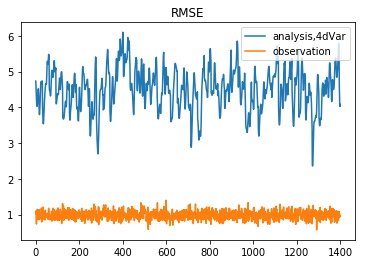

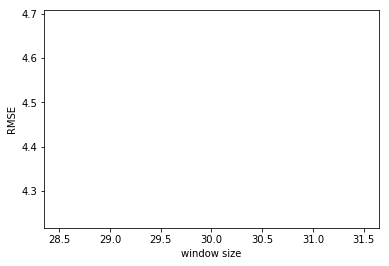

In [28]:
import time
t = 1400
N = 40
h = 0.05 
F = 8.0

dataset = pd.read_csv("observation_data.csv")
y = dataset.values
y = y.reshape(1460,N)
dataset2 = pd.read_csv("data.csv")
Xt = dataset2.values.reshape(1460,N)

#print(Xa)
#print(B)
#X.append(Xa
RMSE=[]
A=[]
for i in range(1):
    start = time.time()
    X = []

    #初期値
    Xa = np.random.randn(N)
    X0 = Xa
    for j in range(500):
        Xa = Rungekutta4(X0,h,F)
        X0 = Xa
    #X.append(Xa)
    
    B = np.eye(N) * 0.2
    
    a_window = 30

    Time=range(0,t,a_window+1)
    #print(list(Time))
    
    for k in Time:
        (Xf,B) = Forecast(Xa,B)
        obs = y[k:k+a_window+1,:]
        #print(obs.shape)
        (Xa,M,MT) = Analysis(Xf,B,obs,a_window)
        X.append(Xa)
        for l in range(a_window):
            Xb = Rungekutta4(Xa,h,F)
            X.append(Xb)
            Xa = Xb
        if(k%100==0):
            print(k)

    elapsed_time = time.time()-start
    print("elapsed_time:{0}".format(elapsed_time) + "[sec]")

    #XA = np.array(X)
#print(Xa)

    C1_ = []
    C2_ = []
    H = np.eye(N)
#H2 = H/2 + np.roll(H,1,axis=1)/2
    for i in range(t):
        X1 = X[i]
        X2 = Xt[i]
        X3 = sum((X2-X1)*(X2-X1))/N
        Y1 = y[i]
    #mask = Y1>=0
    #Y1 = Y1[mask]
    #e = np.eye(N)
    #p = int(np.sum(e[mask]))
        Y2 = sum((H@X2-Y1)*(H@X2-Y1))/N
    #Y2 = sum((H3(X2,mask)-Y1)*(H3(X2,mask)-Y1))/p
        rmse1 = np.sqrt(X3)
        rmse2 = np.sqrt(Y2)
        C1_.append(rmse1)
        C2_.append(rmse2)
    #plt.plot(C1,label="analysis,OI")
    plt.plot(C1_,label="analysis,4dVar")
    plt.plot(C2_,label="observation")
#plt.plot(errcov,label="Pa")
    plt.legend()
    plt.title("RMSE")
    #plt.savefig("4dVar_window"+str(a_window)+"2.jpg")
    plt.show()
    
    r=np.mean(np.array(C1_[500:]))
    RMSE.append(r)
    A.append(a_window)
    
plt.plot(A,RMSE)
plt.xlabel("window size")
plt.ylabel("RMSE")
#plt.savefig("4dVar_windowsize2.jpg")
plt.show()

In [19]:
X=[]
a_window=10
for k in range(0,t,a_window):
    X.append(k)
print(X)

[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 400, 410, 420, 430, 440, 450, 460, 470, 480, 490, 500, 510, 520, 530, 540, 550, 560, 570, 580, 590, 600, 610, 620, 630, 640, 650, 660, 670, 680, 690, 700, 710, 720, 730, 740, 750, 760, 770, 780, 790, 800, 810, 820, 830, 840, 850, 860, 870, 880, 890, 900, 910, 920, 930, 940, 950, 960, 970, 980, 990, 1000, 1010, 1020, 1030, 1040, 1050, 1060, 1070, 1080, 1090, 1100, 1110, 1120, 1130, 1140, 1150, 1160, 1170, 1180, 1190, 1200, 1210, 1220, 1230, 1240, 1250, 1260, 1270, 1280, 1290, 1300, 1310, 1320, 1330, 1340, 1350, 1360, 1370, 1380, 1390, 1400, 1410, 1420, 1430, 1440, 1450]


[[1.00000000e+00 5.00000000e-01 2.50000000e-01 ... 6.31088724e-30
  3.15544362e-30 1.57772181e-30]
 [5.00000000e-01 1.00000000e+00 5.00000000e-01 ... 1.26217745e-29
  6.31088724e-30 3.15544362e-30]
 [2.50000000e-01 5.00000000e-01 1.00000000e+00 ... 2.52435490e-29
  1.26217745e-29 6.31088724e-30]
 ...
 [6.31088724e-30 1.26217745e-29 2.52435490e-29 ... 1.00000000e+00
  5.00000000e-01 2.50000000e-01]
 [3.15544362e-30 6.31088724e-30 1.26217745e-29 ... 5.00000000e-01
  1.00000000e+00 5.00000000e-01]
 [1.57772181e-30 3.15544362e-30 6.31088724e-30 ... 2.50000000e-01
  5.00000000e-01 1.00000000e+00]] [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  9

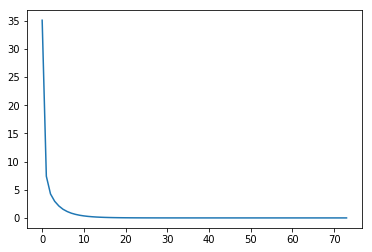

[ 1.          2.          3.          4.          5.          6.
  7.          8.          9.         10.         11.         12.
 13.         14.         15.         16.         17.         18.
 19.         20.         21.         22.         23.         24.
 25.         26.00000001 27.00000001 28.00000001 29.00000001 30.00000001
 31.00000001 32.00000001 33.00000001 34.00000001 35.00000001 36.00000001
 37.00000001 38.00000001 39.00000001 40.00000001 41.00000001 42.00000001
 43.00000001 44.00000001 45.00000001 46.00000001 47.00000001 48.00000001
 49.00000001 50.00000001 51.00000001 52.00000001 53.00000001 54.00000001
 55.00000001 56.00000001 57.00000001 58.00000001 59.00000001 60.00000001
 61.00000001 62.00000001 63.00000001 64.00000001 65.00000001 66.00000001
 67.00000001 68.00000001 69.00000001 70.00000001 71.00000001 72.00000001
 73.00000001 74.00000001 75.00000001 76.00000001 77.00000001 78.00000001
 79.00000001 80.00000001 81.00000001 82.         83.         84.
 85.         86.  

In [42]:
#Gradient descent
N = 100
A = np.ones((N,N))
for i in range(N):
    for j in range(i+1,N):
        A[i,j]=A[i,j]/2**(j-i)
for i in range(N):
    for j in range(i):
        A[i,j]=A[j,i]
b = np.arange(1,N+1)
print(A,b)
E=[]
x0 = b
r = b - A@x0
p = r
for k in range(10000):
    a = np.dot(p,r)/np.dot(p,A@p)
    x = x0 + a*p
    r = b - A@x
    p = r
    x0 = x
    #print(a,x,r)
    err = np.sqrt(np.dot(r,r))
    E.append(err)
    if(err<1e-7):
        print(k,x)
        break
plt.plot(E)
plt.show()
print(A@x)

[[1.00000000e+00 2.50000000e-01 6.25000000e-02 1.56250000e-02
  3.90625000e-03 9.76562500e-04 2.44140625e-04 6.10351562e-05
  1.52587891e-05 3.81469727e-06 9.53674316e-07 2.38418579e-07
  5.96046448e-08 1.49011612e-08 3.72529030e-09 9.31322575e-10
  2.32830644e-10 5.82076609e-11 1.45519152e-11 3.63797881e-12]
 [2.50000000e-01 1.00000000e+00 2.50000000e-01 6.25000000e-02
  1.56250000e-02 3.90625000e-03 9.76562500e-04 2.44140625e-04
  6.10351562e-05 1.52587891e-05 3.81469727e-06 9.53674316e-07
  2.38418579e-07 5.96046448e-08 1.49011612e-08 3.72529030e-09
  9.31322575e-10 2.32830644e-10 5.82076609e-11 1.45519152e-11]
 [6.25000000e-02 2.50000000e-01 1.00000000e+00 2.50000000e-01
  6.25000000e-02 1.56250000e-02 3.90625000e-03 9.76562500e-04
  2.44140625e-04 6.10351562e-05 1.52587891e-05 3.81469727e-06
  9.53674316e-07 2.38418579e-07 5.96046448e-08 1.49011612e-08
  3.72529030e-09 9.31322575e-10 2.32830644e-10 5.82076609e-11]
 [1.56250000e-02 6.25000000e-02 2.50000000e-01 1.00000000e+00
  2.5

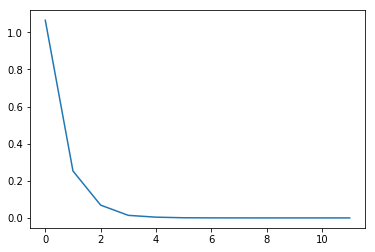

[ 3.32294923e-08  3.11145190e-08  2.19224949e-09 -2.94255895e-08
 -3.16895896e-08  2.41206521e-09  3.44425279e-08  1.29516797e-08
 -2.68196567e-08 -1.09143485e-08  2.90613187e-08 -3.34627508e-08
  3.00600007e-08 -3.79324661e-09 -8.07692935e-09 -7.82746135e-09
  5.19226973e-09  9.16450205e-09 -5.37664135e-10 -8.13333756e-09]


In [64]:
#Conjucate Gradient
N = 20
A = np.ones((N,N))
for i in range(N):
    for j in range(i+1,N):
        A[i,j]=A[i,j]/4**(j-i)
for i in range(N):
    for j in range(i):
        A[i,j]=A[j,i]
b = np.arange(N)
print(A,b)
E=[]
x0 = b
r0 = b - A@x0
p0 = r0
for k in range(10000):
    a = np.dot(p0,r0)/np.dot(p0,A@p0)
    x = x0 + a*p0
    r = r0 - a*A@p0
    err = np.sqrt(np.dot(r,r))
    #print(err)
    E.append(err)
    if(err<1e-7):
        print(k,x)
        break
    y = r-r0
    beta = -np.dot(r,y)/np.dot(p0,y)
    p = r + beta*p0
    
    x0 = x
    p0 = p
    r0 = r
plt.plot(E)
plt.show()
print(A@x-b)

In [5]:
def f(x):
    return x**2-4*x+9

def golden_section():
    a0=-10
    b0=10
    t = (1.0 + np.sqrt(5))/2 #golden_ratio
    a=a0
    b=b0
    c1=(t*a+b)/(1+t)
    c2=(a+t*b)/(1+t)
    num=0
    print(num,a,b,c1,c2,abs(b-a))
    for k in range(1000):
        num+=1
        #x1 = x0 - c1*G0@jacobi(x0)
        f1 = f(c1)
        #x2 = x0 - c2*G0@jacobi(x0)
        f2 = f(c2)
        if(f2>f1):
            a=a
            b=c2
            c2=c1
            c1=(t*a+b)/(1+t)
        else:
            a=c1
            b=b
            c1=c2
            c2=(a+t*b)/(1+t)
        if(abs(b-a)<0.0001):
            print("end")
            break
        print(num,a,b,c1,c2,abs(b-a))
    return a

a = golden_section()
print(a)

0 -10 10 -2.360679774997897 2.360679774997897 20
1 -2.360679774997897 10 2.360679774997897 5.278640450004206 12.360679774997898
2 -2.360679774997897 5.278640450004206 0.5572809000084118 2.360679774997897 7.639320225002103
3 0.5572809000084118 5.278640450004206 2.360679774997897 3.4752415750147208 4.721359549995794
4 0.5572809000084118 3.4752415750147208 1.6718427000252358 2.360679774997897 2.917960675006309
5 0.5572809000084118 2.360679774997897 1.2461179749810727 1.6718427000252358 1.8033988749894854
6 1.2461179749810727 2.360679774997897 1.6718427000252358 1.9349550499537334 1.1145618000168245
7 1.6718427000252358 2.360679774997897 1.9349550499537334 2.0975674250694 0.6888370749726613
8 1.6718427000252358 2.0975674250694 1.834455075140903 1.9349550499537334 0.42572472504416403
9 1.834455075140903 2.0975674250694 1.9349550499537334 1.99706745025657 0.26311234992849686
10 1.9349550499537334 2.0975674250694 1.99706745025657 2.035455024766563 0.1626123751156665
11 1.9349550499537334 2.03

[2.04563955 1.40103839] [47.53186251 32.555283  ]
[[279.27408738 278.27408738]
 [278.27408738 279.27408738]]
[-0.00068637 -0.00068587] [-0.06445413 -0.03700062]
[[279.27182175 278.27182175]
 [278.27182175 279.27182175]]
[-0.00108677 -0.00108584] [-0.10197076 -0.05852312]
[[279.26614214 278.26614214]
 [278.26614214 279.26614214]]
[-0.00196133 -0.00195956] [-0.18377769 -0.10543651]
[[279.24764297 278.24764297]
 [278.24764297 279.24764297]]
[-5.81520065 -5.80977307] [ 87.28816674 -85.64855853]
[[293.00610329 292.00610329]
 [292.00610329 293.00610329]]
[6.23287247 3.36969817] [-90.83870297  92.32865324]
[[69229.30416375 69228.30416375]
 [69228.30416375 69229.30416375]]
[6.83129198 6.83170572] [4203.83322394 1319.37728623]
[[1.81741729e+10 1.81741729e+10]
 [1.81741729e+10 1.81741729e+10]]
[3.99527496e+09 3.99527496e+09] [2.55093865e+29 2.55093864e+29]
[[2.96361184e+50 2.96361184e+50]
 [2.96361184e+50 2.96361184e+50]]
[-1.51198724e+81 -1.51198724e+81] [-1.3826249e+244 -1.3826249e+244]
[[inf 

C:\Users\saori\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in double_scalars
  del sys.path[0]
C:\Users\saori\Anaconda3\lib\site-packages\ipykernel_launcher.py:124: RuntimeWarning: overflow encountered in square
C:\Users\saori\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]
C:\Users\saori\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\saori\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars



[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] 

[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [

[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]


[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]


[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [

[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [

[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]


[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [

[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]


[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [

[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]


[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]


 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]

[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]


[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]


[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [

[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]


[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]


[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]


[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]


[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [

[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [

[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [

[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [

[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [

[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [

[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [

[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [

[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]


[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]


[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [

[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]


[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [

[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]


 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]

[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [

[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [

[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]


[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]


[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]


[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]


[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [

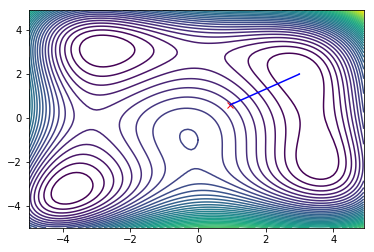

In [6]:
delta = 0.1
minXY=-5.0
maxXY=5.0
nContour=50
alpha=0.01

def J(x,y):
    u"""
    Himmelblau's function
    see Himmelblau's function - Wikipedia, the free encyclopedia 
    http://en.wikipedia.org/wiki/Himmelblau%27s_function
    """
    return (x**2+y-11)**2+(x+y**2-7)**2

def CreateMeshData():
    x = np.arange(minXY, maxXY, delta)
    y = np.arange(minXY, maxXY, delta)
    X, Y = np.meshgrid(x, y)
    Z=[J(x,y) for (x,y) in zip(X,Y)]
    return(X,Y,Z)

def jacobi(x):
    dx = 4*x[0]**3 + 4*x[0]*x[1] - 42*x[0] +2*x[1]**2 -14
    dy = 2*x[0]**2 + 4*x[0]*x[1] + 4*x[1]**3 -26*x[1] -22
    return np.array([dx,dy])

def golden_section(x0,d0):
    a0=-10
    b0=10
    t = 0.618 #golden_ratio
    a=a0
    b=b0
    c1=(1-t)*b + t*a
    c2=(1-t)*a + t*b
    num=0
    #print(num,a,b,c1,c2,abs(b-a))
    for k in range(1000):
        num+=1
        x1 = x0 + c1*d0
        f1 = J(x1[0],x1[1])
        x2 = x0 + c2*d0
        f2 = J(x2[0],x2[1])
        if(f2>f1):
            a=a
            b=c2
            c2_=c1
            c1_=(1-t)*b + t*a
        else:
            a=c1
            b=b
            c1_=c2
            c2_=(1-t)*a + t*b
        if(abs(b-a)<0.0001):
            #print(num,"end")
            break
        c1 = c1_
        c2 = c2_
        #print(num,a,b,c1,c2,abs(b-a))
    return a

def CG(start):
    result=[start]
    x0 = start
    d0 = -jacobi(x0)
    for k in range(10000):
        alpha = golden_section(x0,d0)
        x = x0 + alpha*d0
        result.append(x)
        d = jacobi(x)
        if(np.sqrt(np.sum(d**2))<0.001):
            print(k,"end")
            break
        p = -d + (np.dot(d.T,d)/np.dot(d0.T,d0))*d0
        x0 = x
        d0 = p
    return result

def golden_section_N(x0,G0):
    a0=-10
    b0=10
    t = 0.618 #golden_ratio
    a=a0
    b=b0
    c1=(1-t)*b + t*a
    c2=(1-t)*a + t*b
    num=0
    #print(num,a,b,c1,c2,abs(b-a))
    for k in range(1000):
        num+=1
        x1 = x0 - c1*G0@jacobi(x0)
        f1 = J(x1[0],x1[1])
        #f1 = f(c1)
        x2 = x0 - c2*G0@jacobi(x0)
        f2 = J(x2[0],x2[1])
        #f2 = f(c2)
        if(f2>f1):
            a=a
            b=c2
            c2_=c1
            c1_=(1-t)*b + t*a
        else:
            a=c1
            b=b
            c1_=c2
            c2_=(1-t)*a + t*b
        if(abs(b-a)<0.0001):
            #print(num,"end")
            break
        c1 = c1_
        c2 = c2_
        #print(num,a,b,c1,c2,abs(b-a))
    return a  

def quasi_Newton(start):
    I=np.eye(2)
    G0=np.eye(2)
    x0 = start
    result=[start]
    for k in range(10000):
        alpha = golden_section_N(x0,G0)
        x = x0 - alpha*G0@jacobi(x0)
        
        result.append(x)
        if(np.sqrt(np.sum(jacobi(x)**2))<0.001):
            print(k,"end")
            break
        p0 = x - x0
        q0 = jacobi(x) - jacobi(x0)
        print(p0,q0)
        #p0 = p0.reshape(-1,1)
        #q0 = q0.reshape(-1,1)
        G = (I - p0@q0.T/q0.T@p0)@G0@(I - q0@p0.T/q0.T@p0) + p0@p0.T/q0.T@p0
        print(G)
        G0 = G
        x0 = x
        
    return result
        
start=np.array([random.uniform(minXY,maxXY),random.uniform(minXY,maxXY)])

resultn=quasi_Newton(start)
resultc=CG(start)
(X,Y,Z)=CreateMeshData()
CS = plt.contour(X, Y, Z,nContour)
#  plt.clabel(CS, inline=1, fontsize=10)
#  plt.title('Simplest default with labels')

plt.plot(start[0],start[1],"xr");

if(len(resultn)<1000):
    optX=[x[0] for x in resultn]
    optY=[x[1] for x in resultn]
    plt.plot(optX,optY,"-r");

optX=[x[0] for x in resultc]
optY=[x[1] for x in resultc]
plt.plot(optX,optY,"-b");

plt.show()

In [6]:
def makecsv(m,F,df,fname):
    h=0.05
    t=0.0
    N=40
    
    Xa = np.full((N),F)
    Xa[19] += df
    
    X = []
    time = []
    
    for i in np.arange(1,m):
        Xb = Rungekutta4(Xa,h,F)
        Xa=Xb
        t=t+h
        if i > 1460:
            X.append(Xa)
            time.append(t)
        
    df=pd.DataFrame(X)
    df.to_csv(fname,index=False)
    
    dataset = pd.read_csv(fname)
    print(dataset)
    array = dataset.values
    #print(array)
    
    return array

             0         1          2         3         4         5         6  \
0    -4.577655 -2.752373   0.099049  0.677744  5.934551 -0.679750 -2.954209   
1    -3.492238 -2.382872  -0.132460  1.021116  5.995053 -1.253493 -2.160478   
2    -1.737512 -2.129497  -0.155935  1.296183  6.018508 -1.643000 -1.247249   
3     0.132688 -1.731283   0.028431  1.592421  5.997327 -1.819359 -0.291257   
4     1.660538 -1.145299   0.355962  1.971286  5.920252 -1.806988  0.611892   
5     2.613184 -0.497191   0.727151  2.440736  5.775701 -1.667487  1.387096   
6     2.985288  0.076291   1.083551  2.970887  5.556828 -1.471157  2.000461   
7     2.902180  0.527611   1.426230  3.527653  5.259192 -1.275429  2.454620   
8     2.533719  0.894443   1.785871  4.085551  4.872934 -1.115909  2.770881   
9     2.059085  1.242739   2.197940  4.620592  4.377801 -1.004464  2.972569   
10    1.652102  1.619169   2.693192  5.097779  3.745427 -0.928768  3.077689   
11    1.456050  2.045040   3.288462  5.459081  2.951

            0         1          2         3         4         5         6   \
0    -2.878039  0.591952   0.495855  5.181551  2.075622 -3.674536 -1.694007   
1    -2.190684 -2.247978   0.509388  4.682070  1.510716 -0.271545 -1.146887   
2    -1.532801 -0.987649   1.540610  2.525423  1.563944 -2.766673 -1.431760   
3    -0.748637 -1.277241  -0.372908  5.142575  1.710272 -0.171932  1.561375   
4    -0.404949 -1.918470   1.159875  3.097536  0.991758 -0.066493 -0.493602   
5     0.524430  1.251875   1.061251  4.491702  1.892137  0.604550  0.167412   
6     0.826726  1.459632   2.836240  3.173636 -0.361486  1.409252  0.953429   
7     1.847076  1.436641   3.696785  5.857123  2.476929 -0.454759  3.477741   
8     0.490926  2.459326   2.031457  5.678224  2.648774  1.111371  3.828426   
9     3.240344  2.895107   3.840058  1.817501  2.793296  0.351338  2.118861   
10    0.700037  4.325723   2.857514  5.657431  2.183521  2.233725  5.538915   
11    1.694730  3.683729   4.045428  6.287113  2.524

[[0 1 2 3 4]
 [5 6 7 8 9]] [[ 1  3  5  7  4]
 [11 13 15 17 14]]
[[0.5 0.5 0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.5 0.5 0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.5 0.5 0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.5 0.5 0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.5 0.5 0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.5 0.5 0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.5 0.5 0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.5 0.5 0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.5 0.5]
 [0.5 0.  0.  0.  0.  0.  0.  0.  0.  0.5]]


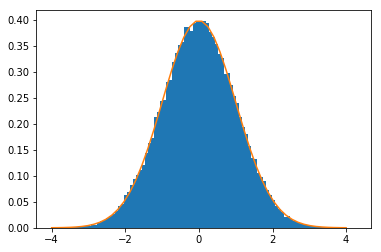

In [46]:
fname="data2.csv"
data = makecsv(2921,8.0,0.008,fname).reshape(1460,-1)
obdata = (data + np.roll(data,-1,axis=1))/2
N = obdata.size
R = []
x = np.linspace(-40,40)
x = x * 0.1
y = np.exp(-x*x/2)/np.sqrt(2*np.pi)
for i in range(N):
    R.append(random.normalvariate(0.0,1.0))
plt.hist(R,bins=100,density=True)
plt.plot(x,y)
oberr = np.array(R).reshape(obdata.shape)
for i in range(1460):
    obdata[i] += oberr[i]
    
df=pd.DataFrame(obdata)
print(df)
df.to_csv("observation_data2.csv",index=False)

d = np.arange(10).reshape(2,5)
d2 = d + np.roll(d,-1,axis=1)
print(d,d2)
H = np.eye(10)
H2 = H/2 + np.roll(H,1,axis=1)/2
print(H2)

             0         1          2         3         4         5         6  \
0    -4.577655 -2.752373   0.099049  0.677744  5.934551 -0.679750 -2.954209   
1    -3.492238 -2.382872  -0.132460  1.021116  5.995053 -1.253493 -2.160478   
2    -1.737512 -2.129497  -0.155935  1.296183  6.018508 -1.643000 -1.247249   
3     0.132688 -1.731283   0.028431  1.592421  5.997327 -1.819359 -0.291257   
4     1.660538 -1.145299   0.355962  1.971286  5.920252 -1.806988  0.611892   
5     2.613184 -0.497191   0.727151  2.440736  5.775701 -1.667487  1.387096   
6     2.985288  0.076291   1.083551  2.970887  5.556828 -1.471157  2.000461   
7     2.902180  0.527611   1.426230  3.527653  5.259192 -1.275429  2.454620   
8     2.533719  0.894443   1.785871  4.085551  4.872934 -1.115909  2.770881   
9     2.059085  1.242739   2.197940  4.620592  4.377801 -1.004464  2.972569   
10    1.652102  1.619169   2.693192  5.097779  3.745427 -0.928768  3.077689   
11    1.456050  2.045040   3.288462  5.459081  2.951

            0          1          2          3         4         5   \
0     3.577971   2.749079  -0.293983   0.598659  5.811769 -0.078188   
1     3.622472   2.604226  -1.616321   1.704935  3.346212  0.836169   
2     0.377964   1.865967   0.623538   0.639134  5.149351  1.959116   
3    -0.163420   2.602643   0.337258   3.100635  7.289955  1.336420   
4     0.714991   0.824683   2.194267   0.340867  7.132901  1.277738   
5     2.224730  -0.354322  -0.143807   3.209669  5.420135  3.099623   
6     1.400655   0.740373   1.614214   2.258896  7.277920  0.785106   
7     3.835424   1.307726   2.956769   0.226678  4.331141  0.730728   
8     1.425617  -0.177745   1.349140   4.904052  3.594727  1.001473   
9     1.778208   2.348198   2.550993   4.129699  5.132724  0.507164   
10    2.349295   1.553389   3.187882   4.647248  4.793212  1.517175   
11    1.056467   0.093178   4.931305   4.050894  4.047635  1.557160   
12    3.266491   1.282032   4.048892   4.797808  1.352703  0.593656   
13    

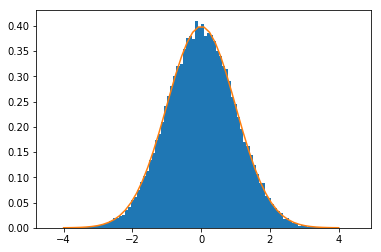

In [7]:

fname="data3.csv"
data = makecsv(2921,8.0,0.008,fname).reshape(1460,-1)
obdata = np.sqrt(data*data)
N = obdata.size
R = []
x = np.linspace(-40,40)
x = x * 0.1
y = np.exp(-x*x/2)/np.sqrt(2*np.pi)
for i in range(N):
    R.append(random.normalvariate(0.0,1.0))
plt.hist(R,bins=100,density=True)
plt.plot(x,y)
oberr = np.array(R).reshape(obdata.shape)
for i in range(1460):
    obdata[i] += oberr[i]
#obdata[obdata<0]=0.0
df=pd.DataFrame(obdata)
print(df)
df.to_csv("observation_data3.csv",index=False)


[[0. 1. 2. ... 3. 2. 1.]
 [1. 0. 1. ... 4. 3. 2.]
 [2. 1. 0. ... 5. 4. 3.]
 ...
 [3. 4. 5. ... 0. 1. 2.]
 [2. 3. 4. ... 1. 0. 1.]
 [1. 2. 3. ... 2. 1. 0.]]
[[1.         0.60653066 0.13533528 ... 0.011109   0.13533528 0.60653066]
 [0.60653066 1.         0.60653066 ... 0.         0.011109   0.13533528]
 [0.13533528 0.60653066 1.         ... 0.         0.         0.011109  ]
 ...
 [0.011109   0.         0.         ... 1.         0.60653066 0.13533528]
 [0.13533528 0.011109   0.         ... 0.60653066 1.         0.60653066]
 [0.60653066 0.13533528 0.011109   ... 0.13533528 0.60653066 1.        ]]


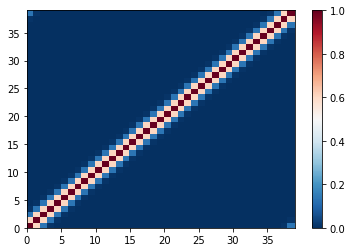

In [14]:
N=40
a=0
p=N-a
sigma=1.0
D = np.zeros((N,p))
L = np.zeros((N,p))

for s in range(N):
    for u in range(N-a):
        D[s,u] = min(abs(s-u),N-abs(s-u))
print(D)        
A=D>5
#print(A)
#print(D[A])
d0=2*np.sqrt(10/3)*sigma
r0=np.exp(-d0**2/(2*sigma**2))
L=np.exp(-D**2/(2*sigma**2))
L[L<r0]=0
x=np.arange(p)
y=np.arange(N)
#P = L*Pf
print(L)
plt.pcolor(x,y,L,cmap='RdBu_r')
plt.colorbar()
#plt.title("L*Pf")
#plt.show()

In [12]:
A = np.array([1,2,0,-3,4,5,0,-6,7,0,8,9]).reshape(3,4)
b = np.array([1,-1,1])
mask = np.empty(A.shape)
m = mask.shape[0]
for i in range(m):
    if(b[i]>0):
        mask[i]=True
    else:
        mask[i]=False
mask = b>0
print(mask)
print(A,A[mask])

[ True False  True]
[[ 1  2  0 -3]
 [ 4  5  0 -6]
 [ 7  0  8  9]] [[ 1  2  0 -3]
 [ 7  0  8  9]]


In [2]:
#3dVar
def L96(Xa,F):
    N=len(Xa)
    
    F_ = (np.roll(Xa, -1) - np.roll(Xa, 2)) * np.roll(Xa, 1) -  Xa + F
    
    return F_

#4次のルンゲクッタ
def Rungekutta4(Xa,h,F):
    N=len(Xa)
    #K1=np.linspace(1,N,N)
    #K2=np.linspace(1,N,N)
    #K3=np.linspace(1,N,N)
    #K4=np.linspace(1,N,N)
    
    F_ = L96(Xa,F)
    K1 = h*F_

    X2=Xa+K1/2
    F_ = L96(X2,F)
    K2=h*F_
    
    X3=Xa+K2/2
    F_ = L96(X3,F)
    K3=h*F_
    
    X4=Xa+K3
    F_ = L96(X4,F)
    K4=h*F_
    
    Xb=Xa+K1/6+K2/3+K3/3+K4/6
    
    return Xb


def J(x,B_inv,H_t,R_inv,d):
    return x.T@B_inv@x/2 + (H_t@x-d).T@R_inv@(H_t@x-d)/2

def jacobi(x,B_inv,H_t,R_inv,d):
    return B_inv@x + H_t.T@R_inv@(H_t@x-d)

def CG(xb,B_inv,H_t,R_inv,d):
    x0 = xb
    d0 = -jacobi(x0,B_inv,H_t,R_inv,d)
    for k in range(1000):
        alpha = golden_section(d0,x0,B_inv,H_t,R_inv,d)
        x = x0 + alpha*d0
        d1 = jacobi(x,B_inv,H_t,R_inv,d)
        err = np.sqrt(np.sum(d1**2))
        #print(k,err)          
        if(np.sqrt(np.sum(d1**2))<0.001):
            #print(k,"end")
            break
        p = -d1 + (np.dot(d1.T,d1)/np.dot(d0.T,d0))*d0
        x0 = x
        d0 = p
    return x

def golden_section(d0,x0,B_inv,H_t,R_inv,d):
    a0=0
    b0=10
    t = (1+np.sqrt(5))/2#golden_ratio
    a=a0
    b=b0
    c1=(t*a+b)/(1+t)
    c2=(a+t*b)/(1+t)
    num=0
    #print(num,a,b,c1,c2,abs(b-a))
    for k in range(100):
        num+=1
        x1 = x0 + c1*d0
        f1 = J(x1,B_inv,H_t,R_inv,d)
        x2 = x0 + c2*d0
        f2 = J(x2,B_inv,H_t,R_inv,d)
        if(f2>f1):
            a=a
            b=c2
            c2=c1
            c1=(t*a+b)/(1+t)
        else:
            a=c1
            b=b
            c1=c2
            c2=(a+t*b)/(1+t)
        if(abs(b-a)<0.0001):
            #print(num,"end",a)
            break
        #print(num,a,b,c1,c2,abs(b-a))
    return a

def J_c(dv,U,H_t,R_inv,d):
    return dv.T@dv/2 + (H_t@U@dv-d).T@R_inv@(H_t@U@dv-d)/2

def jacobi_c(dv,U,H_t,R_inv,d):
    return dv + U.T@H_t.T@R_inv@(H_t@U@dv-d)

def CG_c(dv0,U,H_t,R_inv,d):
    d0 = -jacobi(dv0,U,H_t,R_inv,d)
    for k in range(1000):
        alpha = golden_section_c(d0,dv0,U,H_t,R_inv,d)
        dv = dv0 + alpha*d0
        d1 = jacobi_c(dv,U,H_t,R_inv,d)
        err = np.sqrt(np.sum(d1**2))
        #print(k,err)          
        if(np.sqrt(np.sum(d1**2))<0.001):
            #print(k,"end")
            jmin = J_c(dv,U,H_t,R_inv,d)
            break
        p = -d1 + (np.dot(d1.T,d1)/np.dot(d0.T,d0))*d0
        dv0 = dv
        d0 = p
    return dv,jmin

def golden_section_c(d0,dv0,U,H_t,R_inv,d):
    a0=0
    b0=10
    t = (1+np.sqrt(5))/2#golden_ratio
    a=a0
    b=b0
    c1=(t*a+b)/(1+t)
    c2=(a+t*b)/(1+t)
    num=0
    #print(num,a,b,c1,c2,abs(b-a))
    for k in range(100):
        num+=1
        dv1 = dv0 + c1*d0
        f1 = J_c(dv1,U,H_t,R_inv,d)
        dv2 = dv0 + c2*d0
        f2 = J_c(dv2,U,H_t,R_inv,d)
        if(f2>f1):
            a=a
            b=c2
            c2=c1
            c1=(t*a+b)/(1+t)
        else:
            a=c1
            b=b
            c1=c2
            c2=(a+t*b)/(1+t)
        if(abs(b-a)<0.0001):
            #print(num,"end",a)
            break
        #print(num,a,b,c1,c2,abs(b-a))
    return a



def H3(X,mask):
    X_=X[mask]
    return np.sqrt(X_*X_)
def H3_t(X,dX,mask):
    H = np.diag(np.sqrt(X*X)/X)
    Ht = H[mask]
    return Ht@dX
def H3_adj(X,dY,mask):
    H = np.diag(np.sqrt(X*X)/X)
    Hadj = H[mask].T
    return Hadj@dY

def Forecast(Xa,B):
    h = 0.05
    F = 8.0
    a = 1.1
    
    X1 = Xa
    M = np.eye(N)
    #for i in range(5):
    Xf = Rungekutta4(X1,h,F)
        #M_ = get_linear(X1,h,F)
        #M = M_ @ M
    X1 = Xf
    
    #M = get_linear(Xa,h,F,N)
    #Pf = M @ Pa @ M.T #カルマンフィルターでは時間発展する、3次元変分法では定数
    Pf = B
    
    return Xf,Pf

def Analysis(Xf,Pf,y):
    H = np.eye(N)
    H2 = H/2 + np.roll(H,1,axis=1)/2
    mask = y>=0
    y_ = y[mask]
    e = np.ones(N)
    p = int(np.sum(e[mask]))
    #R = np.eye(p)
    R = np.eye(N)
    I = np.eye(N)
    
    
    d = y - H @ Xf
    #d = y_ - H3(Xf,mask)
    R_inv=np.linalg.inv(R)
    B_inv=np.linalg.inv(Pf)
    
    Ex = np.eye(N)
    Ey = np.eye(p)
    H3t=np.zeros((N,p))
    H3adj=np.zeros((p,N))
    for i in range(N):
        H3t[i] = H3_t(Xf,Ex[i],mask)
    for i in range(p):
        H3adj[i] = H3_adj(Xf,Ey[i],mask)
    H3t = H3t.T
    H3adj = H3adj.T
    #print(H3t,H3adj)
   
    xb=np.zeros(N)
    U = np.linalg.cholesky(B) #cholesky decomposition
    dv0 = np.zeros(N)
    #X = CG(xb,B_inv,H,R_inv,d)
    dv,jmin = CG_c(dv0,U,H,R_inv,d)
    X = U@dv
    Xa = X + Xf
    
    return Xa,jmin

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
elapsed_time:6.871998071670532[sec]


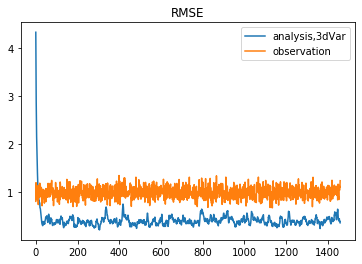

<Jmin> 21.03954444456094


In [4]:
import time

start = time.time()

t = 1460
N = 40
h = 0.05 
F = 8.0

X = []
P = []
Pt2 = []
P2 = []
errcov = []
Jmin = []

dataset = pd.read_csv("observation_data.csv")
y = dataset.values
y = y.reshape(1460,N)
dataset2 = pd.read_csv("data.csv")
Xt = dataset2.values.reshape(t,N)

#初期値
Xa = np.random.randn(N)
X0 = Xa
for j in range(500):
    Xa = Rungekutta4(X0,h,F)
    X0 = Xa
B = np.eye(N) * 0.2
#print(Xa)
#print(B)
#X.append(Xa
    


for k in range(t):
    (Xf,Pf) = Forecast(Xa,B)
    (Xa,jmin) = Analysis(Xf,Pf,y[k,:])
    X.append(Xa)
    Jmin.append(jmin)
    if(k%100==0):
        print(k)

elapsed_time = time.time()-start
print("elapsed_time:{0}".format(elapsed_time) + "[sec]")

Xa = np.array(X)
#print(Xa)

C1_ = []
C2_ = []
H = np.eye(N)
H2 = H/2 + np.roll(H,1,axis=1)/2
for i in range(1460):
    X1 = Xa[i]
    X2 = Xt[i]
    X3 = sum((X2-X1)*(X2-X1))/N
    Y1 = y[i]
    #mask = Y1>=0
    #Y1 = Y1[mask]
    #e = np.eye(N)
    #p = int(np.sum(e[mask]))
    Y2 = sum((H@X2-Y1)*(H@X2-Y1))/N
    #Y2 = sum((H3(X2,mask)-Y1)*(H3(X2,mask)-Y1))/p
    rmse1 = np.sqrt(X3)
    rmse2 = np.sqrt(Y2)
    C1_.append(rmse1)
    C2_.append(rmse2)
#plt.plot(C1,label="analysis,OI")
plt.plot(C1_,label="analysis,3dVar")
plt.plot(C2_,label="observation")
#plt.plot(errcov,label="Pa")
plt.legend()
plt.title("RMSE")
#plt.savefig("3dVar-OI_3.jpg")
plt.show()

print("<Jmin>",np.mean(np.array(Jmin)))